# 【問題1】K-meansクラスの作成

【# 問題1】K-meansクラスの作成
非階層クラスタリングの手法であるK-meansのクラスを作成してください。名前はScratchKMeansとしてください。  
教師なし学習であるクラスタリングになるため、ここまでの回帰や分類とは異なるパイプラインを作成することになります。  
メソッドやパラメータなどはscikit-learnを参考にしてください。  
[sklearn.cluster.KMeans — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)  
検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。  
クラスタリングのための人工データセット  
クラスタリングを実験するための人工データセットを作成するコードを用意しました。スクラッチの過程で利用してください。  
このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。  

シンプルデータセット3

from sklearn.datasets import make_blobs  
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

目的関数  
K-meansは以下のクラスタ内誤差平方和（SSE, Sum of Squared Errors）を最小化する  
${r_{nk}}$と${μ_k}$を求めることで学習を行います。この数式自体は学習時にはコーディングする必要がありませんが、クラスタ数${K}$  
 を決めるためのエルボー法で使います。エルボー法の実装は問題2で扱います。  
$${SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2}$$  
${n}$ : データ点のインデックス    
${k}$ : クラスタのインデックス  
${X_n}$ : n番目のデータ点  
${μ_k}$ :${k}$番目の中心点  
${r_{nk}}$ : データ点  
${X_n}$がクラスタ${k}$に所属していたら1、そうでなければ0  

学習
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。

中心点${μ_k}$を固定した上で${J}$を最小化する${r_{nk}}$を選ぶ。
${r_{nk}}$を固定した上で${J}$を最小化する${μ_k}$を選ぶ。
具体的には以下を行います。

まずは中心点${μ_k}$の初期値を決める。
その後以下を繰り返します。
データ点${X_n}$を最も近い${μ_k}$に割り当てる。
中心点${μ_k}$を${k}$番目のクラスタに割り当てられる全てのデータ点${X_n}$の平均値（重心）に移動する。  
次のどれかの条件を満たしたらこれを止めます。  

繰り返しが指定した回数に到達する。  
中心点${μ_k}$と重心の差が指定した許容値以下になる。  
データ点${X_n}$のクラスタへの割り当てが変化しなくなる。  
さらに、ここまでの一連の流れを指定した回数繰り返す。  
SSEが最小になったものを最終的な学習結果とする。  
これで学習が完了します。  

考慮すべき点として、空のクラスタが生じる可能性があります。これを防ぐためには以下の動作を実装します。  
${k}$番目のクラスタに割り当てられるデータ点${X_n}$が存在しない場合、中心点${μ_k}$を最も離れているデータ点の場所に移動する。  
繰り返し回数や許容値などのハイパーパラメータの値はscikit-learnのデフォルト値を参考にしてください。  

## ユークリッド距離
K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル 
${p,q}$に対しては以下の数式で表現できます。  
$${\|q-p\| = \sqrt{(q-p)\cdot(q-p)}}$$
NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。  
参考  
[numpy.linalg.norm — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.norm.html)

## 初期値
K-meansの学習結果は中心点${μ}$の初期値に影響を受けます。
最もシンプルな初期値の決定方法は、データ点${X_n}$の中からランダムに${k}$個選ぶことです。今回はこれを実装してください。  
  
K-meansのより良い初期値の選択方法については研究が行われており、いろいろな方法が提案されています。

## 推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。  
データ点${X_n}$に対し、学習で決まった中心点${μ_k}$の元、${J}$を最小化する${r_{nk}}$を選ぶ。  
具体的には次のことです。  
データ点${X_n}$を最も近い${μ_k}$に割り当てる。

In [3]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn.datasets import make_blobs
import random
from numpy import *
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import cm
import seaborn as sns

In [13]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=1.0, shuffle=True, random_state=3)

## 【問題2】エルボー法の実装
K-meansにおいて中心点の個数${k}$は人為的に決める必要があるが、その判断方法としてエルボー法があります。  
SSEを縦軸、クラスタ数${k}$を横軸にした折れ線グラフを表示します。  
このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

In [29]:
class KM_scratch:
    def __init__(self, k=4, tol=0.01, max_iter=500):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    

    def fit(self,X):
        self.X = X
        self.centroids = {}
        self.classifications_label =[]
        data = self.X[np.random.choice(self.X.shape[0],self.k,replace=False)]
        self.classifications_label_place =[]
        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}
            self.classifications_label =[]

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in self.X:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances)) #一番近い位置の分類を入れている
                self.classifications[classification].append(featureset) #分類ラベルに分類された点を入れている #ここがかいぜんの余地あり
                self.classifications_label.append(classification)
            
            max_distance=0
            if len(np.unique(self.classifications_label)) != self.k: #分類したラベルが空になっている時の処理
                for i in range(self.k):
                    if i not in np.unique(self.classifications_label):
                        distance = [np.linalg.norm(self.X -self.centroids[centroid]) for centroid in self.centroids] #距
                        distance = max(distance)
                        max_distance= max(max_distance,distance)
                for i in range(self.k):
                    print(np.where((self.X - self.centroids[i])== max_distance))
                    j = np.where((self.X - self.centroids[i])== max_distance)[0][0]
                    self.centroids[i,:] = self.X[j,:]
                        
            self.classifications_label_place.append(self.classifications_label)
#             self.classifications_label =[]
            prev_centroids = dict(self.centroids)
            for classification in self.classifications:
                self.centroids[classification] = np.mean(self.classifications[classification],axis=0) #ここで重心を出している
            
            optimized = True
        
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    optimized = False

            if optimized:
                pass
#                 break
            
    def plot_k_m_label(self):
        plt.scatter(self.X[:,0],self.X[:,1], c=self.classifications_label_place[-1])
#   
    
    def sse(self):
        np_classfication = self.classifications_label_place[-1]
        X_len = self.X.shape[0]
        K_len = self.k
        X2 = np.zeros((X_len,K_len))
        for n in range(X_len):
            for k in range(self.k):
                X2[n,k] = np.linalg.norm(self.X[n] - self.centroids[k])**2


        sse= np.sum(np.sum(np.identity(self.k)[np_classfication] * X2))
        return sse
    
    def predict(self, X):
        classifications_label=[]
        # self.cluster_centers_と各データ点との距離を計算
        for featureset in self.X:
            distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
            classification = distances.index(min(distances)) #一番近い位置の分類を入れている
#             self.classifications[classification].append(featureset) #分類ラベルに分類された点を入れている
            classifications_label.append(classification)
#             self.classifications_label
        return np.array(classifications_label)[:, np.newaxis]

    def degree_of_aggregation(self, X):
            """
            凝集度を計算する

            Parameters
            ----------
            X : 次の形のndarray, shape (n_samples, n_features)
                サンプル

            Returns
            -------
            aggregation : nadarray, shape(n_samples, )
                凝集度

            """
            #凝集度の初期化
            aggregation = np.zeros([X.shape[0],])
            np_as_class_label = np.array(self.classifications_label)
            #クラスターの数だけ繰り返す
            for j in range(self.k):
                #クラスターが一致するデータのみを抽出
                X_same_cluster = X[np.where(np_as_class_label==j)[0]]
                #一時的に凝集度を格納するリスト
                aggregation_i = np.array([])

                #クラスターが一致するデータの数だけ繰り返す
                for i in range(X_same_cluster.shape[0]):
                    #データ毎に凝集度を計算する
                    aggregation_i = np.append(aggregation_i, np.mean(np.linalg.norm(X_same_cluster[i] - X_same_cluster, ord=2, axis=1)))

                #クラスタ別に計算した凝集度を配列に格納する
                aggregation[np.where(np_as_class_label==j)] = aggregation_i

            return aggregation

    
    def degree_of_divergence(self, X):
        """
        乖離度を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        
        Returns
        -------
        divergence : nadarray, shape(n_samples, )
            乖離度
                
        """
        #乖離度の初期化
        divergence = np.array([])
        np_as_class_label = np.array(self.classifications_label)
        for i in range(X.shape[0]):
            #最も近いクラスタがどこか判定する
            distances = [np.linalg.norm(X[i]-self.centroids[centroid]) for centroid in self.centroids]
            classification = distances.index(sort(distances)[1]) #一番近い位置の分類を入れている
            #最も近いクラスタに属するデータのリストを作成する
            X_near_cluster = X[np.where(np_as_class_label==classification)[0]]

            #最も近いクラスタに属するデータと距離の平均を配列に加える
            divergence = np.append(divergence, np.mean(np.linalg.norm(X[i] - X_near_cluster, ord=2, axis=1)))

        return divergence
    

    def plot_silhouette(self, X):
            """
            シルエット図を出力する
            Parameters
            ----------
            X : 次の形のndarray, shape (n_samples, n_features)
                サンプル

            Returns
            -------
            plot
                シルエット図

            """
            #凝集度を計算する
            an = self.degree_of_aggregation(X)
            #乖離度を計算する
            bn = self.degree_of_divergence(X)
            #凝集度と乖離度を列で結合
            an_bn = np.concatenate([an.reshape(an.shape[0],1), bn.reshape(bn.shape[0],1)], axis=1)
            #各データのシルエット係数
            silhouette_vals = (bn - an) / np.max(an_bn, axis=1)
            #シルエット係数の平均値
            silhouette_avg = np.mean(silhouette_vals)
            #各データ点のクラスララベル名
            y_km = self.classifications_label
            #クラスタのラベル名のリスト
            cluster_labels = np.arange(0, self.k, 1)
            #クラスタ数
            n_clusters = self.k
            #シルエット図を出力する
            y_ax_lower, y_ax_upper = 0, 0
            yticks = []
            for i, c in enumerate(cluster_labels):
                c_silhouette_vals = silhouette_vals[y_km == c]
                c_silhouette_vals.sort()
                y_ax_upper += len(c_silhouette_vals)
                color = cm.jet(i / n_clusters)
                plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
                yticks.append((y_ax_lower + y_ax_upper) / 2)
                y_ax_lower += len(c_silhouette_vals)

            plt.axvline(silhouette_avg, color="red", linestyle="--")
            plt.yticks(yticks, cluster_labels + 1)
            plt.ylabel('Cluster')
            plt.xlabel('Silhouette coefficient')
            plt.show()


## 【問題4】クラスタ数kの選択
最適だと思われるクラスタ数${k}$を選択してください。  
エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。  
選択した上で、なぜそれを選んだか説明してください。

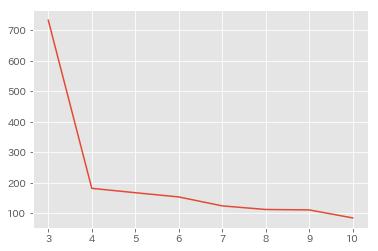

In [30]:
sse_plot = []
sse_index =[]
for i  in  range(3,11):
    km = KM_scratch(i, max_iter=30)
    km.fit(X)
    sse_plot.append(km.sse())
    sse_index.append(i)
    
plt.plot(sse_index,sse_plot)


エルボー法を見た限りにおいては急激な勾配は４から落ち着く。

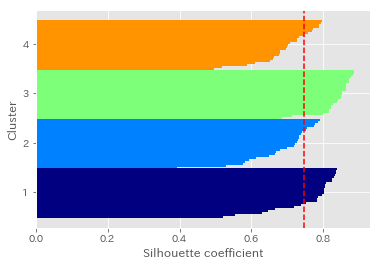

In [31]:
#シルエット図を出力する
km = KM_scratch(4, max_iter=30)
km.fit(X)
km.plot_silhouette(X)

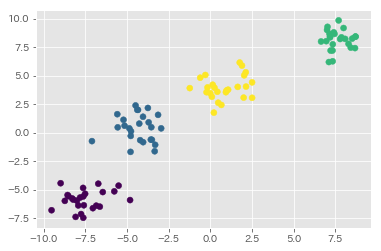

In [32]:
km.plot_k_m_label()

## 卸売業者のデータ分析  
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。  
  
[UCI Machine Learning Repository: Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)
  
Data Folderの中からWholesale customers data.csvをダウンロードしてください。  
これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。  
中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。  
顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

## 次元削減
金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。  
これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

In [34]:
df = pd.read_csv("Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [35]:
sales = df
data = sales.drop(['Channel','Region'], axis=1)
X1 = np.log(data)
X1 = X1.values

In [36]:
pca = PCA(n_components = 2)
pca = pca.fit(X1)
data_pca = pca.transform(X1)

In [37]:
km = KM_scratch(4 ,max_iter=30)

In [38]:
km.fit(data_pca)

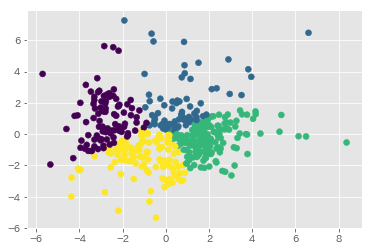

In [39]:
km.plot_k_m_label()

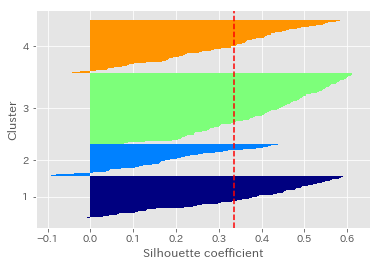

In [40]:
km.plot_silhouette(data_pca)

## 【問題5】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。  
クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

## 確認結果
### RegionとChannelのデータについて
- カテゴリカルデータでRegionとChannel間で相関関係はないように思われる。→　散布図よりプロットされたクラスタは全てまとまっておらず、また直線上に配置されるようになっていることから。

### Region、Channel以外のデータについて
- データに相関関係及び連続性があるように見える　→　散布図のクラスタが近い位置でまとまっている為。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA

# 小数点表示は2桁まで
pd.options.display.precision = 2

# データ読み込み
df = pd.read_csv("Wholesale customers data.csv")

#PCA
pca = PCA(n_components = 2)
pca = pca.fit(df)
data_pca = pca.transform(df)
#Channel列の抽出
channel = np.array(df)[:,0]

#Region列の抽出
region = np.array(df)[:,1]

<function matplotlib.pyplot.show(*args, **kw)>

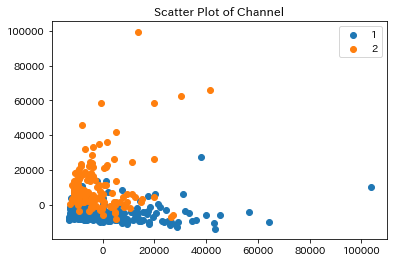

In [3]:
for i in np.unique(channel):
    plt.scatter(data_pca[np.where(channel==i)][:,0], data_pca[np.where(channel==i)][:,1], label=i)
plt.title('Scatter Plot of Channel')
plt.legend()
plt.show

channelは分類可

<function matplotlib.pyplot.show(*args, **kw)>

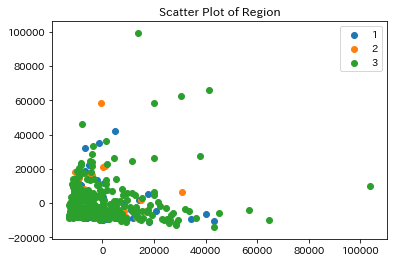

In [4]:
for i in np.unique(region):
    plt.scatter(data_pca[np.where(region==i)][:,0], data_pca[np.where(region==i)][:,1], label=i)
plt.title('Scatter Plot of Region')
plt.legend()
plt.show

regionは分類不可

# 【問題6】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

ヒント

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。

条件ごとにデータを見る際にはPandasのgroupbyが便利です。

[pandas.DataFrame.groupby — pandas 0.23.4 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)

# 今回の課題においての有益な情報の定義
## →<font color="Red"><u>売上・利益の向上を行う為の情報</u></font>と定義


# データ分析の結果により検討した有益な情報
## 用語の意味
- Hoterica(ホテル・レストラン・カフェ) Retail(小売業者)
- Lisbon(リスボン)、Oporto(ポルト)、Other Region(その他の地域)



##  ◯取引先の数について
### 1. Retailの取引先を増やす


- 理由:全体的な取引先を増やす事は、売上・利益の向上には必要ではあるが、現状、Retail(その他)の取引数はHoterica(ホテル・レストラン・カフェ)の半分程度の為、特にRetailの取引先を増やす事が重要と思われる。

## ◯商品について
### 1. RetailへのMilk・Groceryの取引数を増やす
- 理由:Retail(その他)へのMilk(乳製品)Grocery(食料品)の１取引あたりの額が、HoReCa(ホテル・レストラン・カフェ)と比較し高い傾向がある

### 2. Region3でのRetailに対してのGroceryの取引を増やす
- 理由:1回の取引額がその他の地域Region1(Lisbon), Region2(Oporto)、その他の顧客Hotericaと比較し高い為。

### 3. FrozenのHorecaに対しての取引を増やす
- 理由:1回の取引額がその他の地域Region1(Lisbon), Region2(Oporto)、その他の顧客Hotericaと比較し高い為。





# データセットの情報
## ①事前情報
- データの入手先　→　カリフォルニア大学アーバイン校
- データセットの概要　→　ポルトガルの卸売業者の顧客のデータ（2011年(通年)、通貨単位の年間支出）。大元のデータベースからサンプリングしたデータセット。

## ②データについて
### 基本情報
- 特徴量　8個


1. FRESH  ：生鮮品の年間支出（通貨単位）
2. MILK   ：乳製品の年間支出（通貨単位）
3. GROCERY：食料品の年間支出（通貨単位）
4. FROZEN ：冷凍品の年間支出（通貨単位）
5. DETERGENTS_PAPER：洗剤、紙製品の年間支出（通貨単位）
6. DELICATESSEN：デリカテッセン(惣菜)の年間支出（通貨単位）
7. CHANNEL：販売チャネル - Horeca（ホテル/レストラン/カフェ）、卸売業者
8. REGION ：消費地域 - リスボン、ポルト、その他

### 要的統計量(公式ページから確認)


| Product          | Minimum | Maximum | Mean    | Std Deviation |
|------------------|---------|---------|---------|---------------|
| FRESH            | 3       | 112151  | 12000.3 | 12647.329     |
| MILK             | 55      | 73498   | 5796.27 | 7380.377      |
| GROCERY          | 3       | 92780   | 7951.28 | 9503.163      |
| FROZEN           | 25      | 60869   | 3071.93 | 4854.673      |
| DETERGENTS_PAPER | 3       | 40827   | 2881.49 | 4767.854      |
| DELICATESSEN     | 3       | 47943   | 1524.87 | 2820.106      |



| REGION       | Frequency |
|--------------|-----------|
| Lisbon       | 77        |
| Oporto       | 47        |
| Other Region | 316       |
| Total        | 440       



| CHANNEL | Frequency |
|---------|-----------|
| Horeca  | 298       |
| Retail  | 142       |
| Total   | 440       |



## ③データの内容を確認
### <u>ChannelとRegionの値が何を示しているのか？</u>
### 1. Channelの値毎の各特徴量の値を確認
#### 確認した事→ <u>Channel 1</u> は<font color="Red">Horeca</font>　<u>Channel 2</u> は　<font color="Red">Retail</font>であることを確認。
#### 理由→以下のデータフレームのDelicassen(惣菜の年間支出)の値がHorecaとRetailのそれぞれの頻度値と一致している

In [5]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn.datasets import make_blobs
import random
from numpy import *
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import cm

In [6]:
# データフレームの呼び出し
df = pd.read_csv('Wholesale customers data.csv')
# df = pd.read_csv('Wholesale customers data.csv', index_col=0)
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### 2. Regionの値毎の各特徴量の値を確認
#### 確認した事→ <u>Region 1</u> は<font color="Red">Lisbon</font>　<u>Region 2</u> は　<font color="Red">Oporto</font>　<u>Region 3</u> は<font color="Red">Other Region</font>であることを確認。
#### 理由→以下のデータフレームのDelicassen(惣菜の年間支出)の値がRegionのHorecaとRetailのそれぞれの頻度値と一致している  
  
## →②からの推察

In [7]:
df.groupby(['Region']).count()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1,77,77,77,77,77,77,77
2,47,47,47,47,47,47,47
3,316,316,316,316,316,316,316


## ④データ分布を確認
### 4-1 Channel毎のデータフレーム

In [8]:
# Horecaのみのデータ
df_Channel1 = df[df['Channel']==1].drop(['Channel'],axis=1)
# Retailのみのデータ
df_Channel2 = df[df['Channel']==2].drop(['Channel'],axis=1)

### 4-2 Region毎のデータフレーム

In [9]:
# Lisbonのみのデータ
df_Region1 = df[df['Region']==1].drop(['Region'],axis=1)
# Oportoのみのデータ
df_Region2 = df[df['Region']==2].drop(['Region'],axis=1)
# Other Regionのみのデータ
df_Region3 = df[df['Region']==3].drop(['Region'],axis=1)

### Fresh(生鮮食品の売り上げの分布)
### 4-3 Channel毎のデータの推移→特に有益な情報な無し。

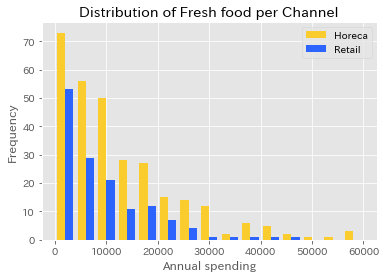

In [10]:
plt.hist([df_Channel1['Fresh'],df_Channel2['Fresh']],
         bins=15, label=['Horeca','Retail'], color=['#FACC2E','#2E64FE'], range=(0,60000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Fresh food per Channel')
plt.legend()

### 4-4 Region毎のデータの推移→特に有益な情報な無し。
高い支出は頻度が少ないということしか分からない。

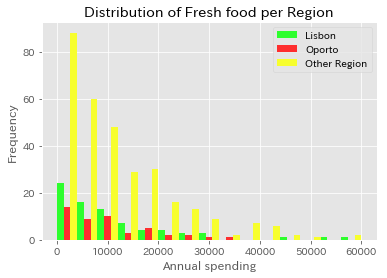

In [11]:
plt.hist([df_Region1['Fresh'],df_Region2['Fresh'],df_Region3['Fresh']],
         bins=15, label=['Lisbon','Oporto','Other Region'], color=['#2EFE2E','#FE2E2E','#F7FE2E'], rwidth=100, range=(0,60000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Fresh food per Region')
plt.legend();

### Milk(乳製品)の分布
### 4-5 Channel毎のデータの推移→Retailの方が、取引先あたりの卸売額が大きい傾向がある
レストランやホテルの方が質が悪いとは思わないが業務用を使っている？

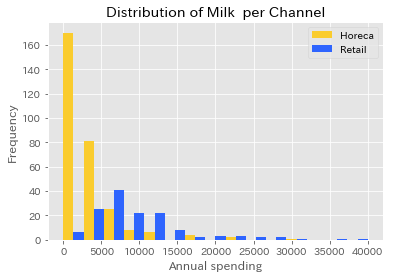

In [12]:
plt.hist([df_Channel1['Milk'],df_Channel2['Milk']],
         bins=15, label=['Horeca','Retail'], color=['#FACC2E','#2E64FE'], rwidth=100, range=(0,40000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Milk  per Channel')
plt.legend();

### 4-6 Region毎のデータの推移→特に有益な情報な無し。

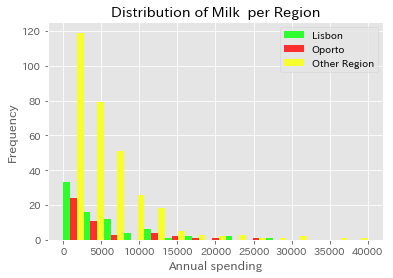

In [13]:
plt.hist([df_Region1['Milk'],df_Region2['Milk'],df_Region3['Milk']],
         bins=15, label=['Lisbon','Oporto','Other Region'], color=['#2EFE2E','#FE2E2E','#F7FE2E'], rwidth=100, range=(0,40000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Milk  per Region')
plt.legend();

### Grocery(食料品)の分布
### 4-7 Channel毎のデータの推移→Retailの方が、取引先あたりの卸売額が大きい傾向がある
やはりホテルやレストランの方が安い品を扱っているのか？
ここらあたりからRetailの取り扱いを増やす事が重要に思える。

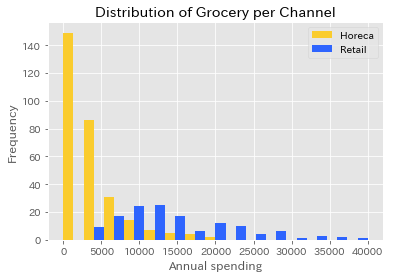

In [14]:
plt.hist([df_Channel1['Grocery'],df_Channel2['Grocery']],
        bins=15, label=['Horeca','Retail'], color=['#FACC2E','#2E64FE'], rwidth=100, range=(0,40000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Grocery per Channel')
plt.legend();

### 4-8 Region毎のデータの推移→Other Region方が、取引先あたりの卸売額が大きい傾向がある。

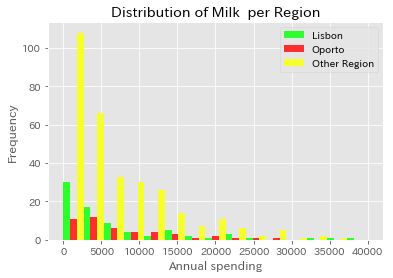

In [15]:
plt.hist([df_Region1['Grocery'],df_Region2['Grocery'],df_Region3['Grocery']],
        bins=15, label=['Lisbon','Oporto','Other Region'], color=['#2EFE2E','#FE2E2E','#F7FE2E'], rwidth=100, range=(0,40000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Milk  per Region')
plt.legend();

### Frozen(冷凍食品)の分布
### 4-9 Channel毎のデータの推移→Horecaの方が、取引先あたりの卸売額が大きい傾向がある

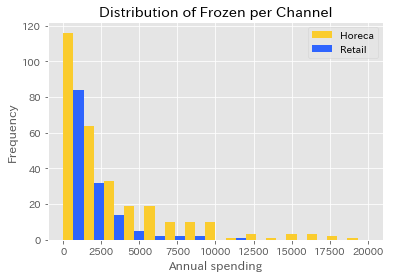

In [16]:
plt.hist([df_Channel1['Frozen'],df_Channel2['Frozen']],
        bins=15, label=['Horeca','Retail'], color=['#FACC2E','#2E64FE'], rwidth=100, range=(0,20000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Frozen per Channel')
plt.legend();

### 4-10 Region毎のデータの推移→特に有益な情報な無し。

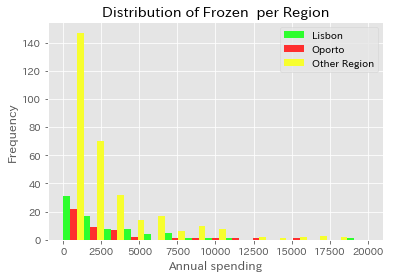

In [17]:
plt.hist([df_Region1['Frozen'],df_Region2['Frozen'],df_Region3['Frozen']],
        bins=15, label=['Lisbon','Oporto','Other Region'], color=['#2EFE2E','#FE2E2E','#F7FE2E'], rwidth=100, range=(0,20000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Frozen  per Region')
plt.legend();

### Detargents_Paper(洗剤、紙製品)の分布
### 4-11 Channel毎のデータの推移→洗剤、紙製品はRetailの方が、<u>取引先あたりの卸売額が大きい傾向がある</u>
多分ホテルなどは買い置きしている客のための備品として恒常的にかつ安い品を購入しているのかも知れない。

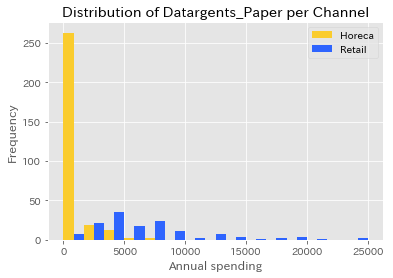

In [18]:
plt.hist([df_Channel1['Detergents_Paper'],df_Channel2['Detergents_Paper']],
        bins=15, label=['Horeca','Retail'], color=['#FACC2E','#2E64FE'], rwidth=100, range=(0,25000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Datargents_Paper per Channel')
plt.legend();

### 4-12 Region毎のデータの推移→特に有益な情報な無し。

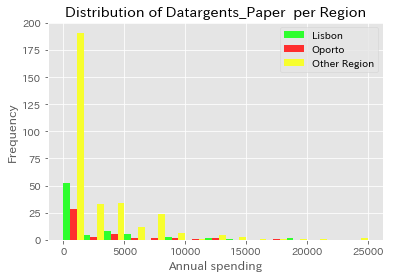

In [19]:
plt.hist([df_Region1['Detergents_Paper'],df_Region2['Detergents_Paper'],df_Region3['Detergents_Paper']],
        bins=15, label=['Lisbon','Oporto','Other Region'], color=['#2EFE2E','#FE2E2E','#F7FE2E'], rwidth=100, range=(0,25000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Datargents_Paper  per Region')
plt.legend();

### Delicatessen(惣菜)の分布
### 4-13 Channel毎のデータの推移→特に有益な情報な無し。

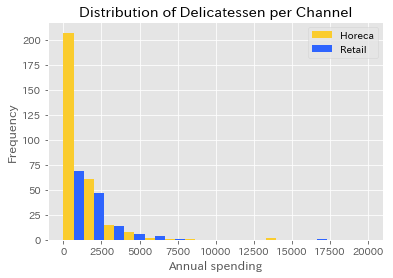

In [20]:
plt.hist([df_Channel1['Delicassen'],df_Channel2['Delicassen']],
        bins=15, label=['Horeca','Retail'], color=['#FACC2E','#2E64FE'], rwidth=100, range=(0,20000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Delicatessen per Channel')
plt.legend();

### 4-14 Region毎のデータの推移→特に有益な情報な無し。

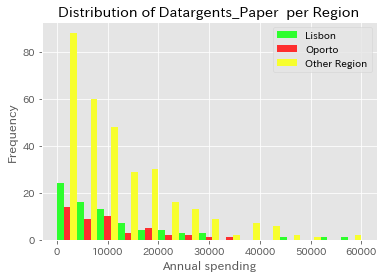

In [21]:
plt.hist([df_Region1['Fresh'],df_Region2['Fresh'],df_Region3['Fresh']],
         bins=15, label=['Lisbon','Oporto','Other Region'], color=['#2EFE2E','#FE2E2E','#F7FE2E'], rwidth=100, range=(0,60000))
plt.ylabel('Frequency')
plt.xlabel('Annual spending')
plt.title('Distribution of Datargents_Paper  per Region')
plt.legend();

## ⑤クロス集計を実施
### <u>Regionでグループ化</u>
### 5-1 取引先の数→Other Region, Lisbon, Oportoの順で多い

In [22]:
df['Total'] = df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].sum(axis=1)
df[['Region','Total']].groupby(['Region']).count()

,Total
Region,
1,77
2,47
3,316


### 5-2 Region毎の取引額の合計→Region3(Other) Region1(Lisbon), Region2(Oporto)の順で多い

In [23]:
df.drop('Channel',axis=1).groupby(['Region']).sum()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total
Region,,,,,,,
1,854833,422454,570037,231026,204136,104327,2386813
2,464721,239144,433274,190132,173311,54506,1555088
3,3960577,1888759,2495251,930492,890410,512110,10677599


### 5-3 取引先あたりの取引額の平均→Region3(Other) Region2(Lisbon), Region1(Oporto)の順で多い
- Region2(Lisbon)は取引額の合計では最低だが、取引額の平均では第２位となっており、<u>1回あたりの取引額が高いことがわかる。</u>

In [24]:
df.drop('Channel',axis=1).groupby(['Region']).mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total
Region,,,,,,,
1,11101.73,5486.42,7403.08,3000.34,2651.12,1354.9,30997.57
2,9887.68,5088.17,9218.60,4045.36,3687.47,1159.7,33086.98
3,12533.47,5977.09,7896.36,2944.59,2817.75,1620.6,33789.87


### <u>Channelでグループ化</u>
### 5-4 取引先の数を見てみる→取引先の数は、Horecaが倍近く多い

In [25]:
df[['Channel','Total']].groupby(['Channel']).count()

,Total
Channel,
1,298
2,142


#### Channel毎の取引額
- Horecaは、Retailに対して倍近い取引があるにもかかわらず、<u>卸売額はそれほど大きな差がない</u>
- Fresh, Grocery, Frozenの順で取引額が多い

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA

# 小数点表示は2桁まで
pd.options.display.precision = 2

# データ読み込み
data = pd.read_csv("Wholesale customers data.csv")

# 顧客ID番号列を追加
customer_id = pd.DataFrame(np.arange(data.shape[0]), columns=["Customer ID"])
data = pd.concat((customer_id, data), axis=1)

# 欠損値の確認
print("欠損値の有無：", data.isnull().sum().sum())

# データの外観
data.head()

欠損値の有無： 0


,Customer ID,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


/anaconda3/envs/DIC/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Explained variance:  [0.44237417 0.27657107 0.11617342 0.09617719 0.0457568  0.02294735]
Cumulative explained variance:  [0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


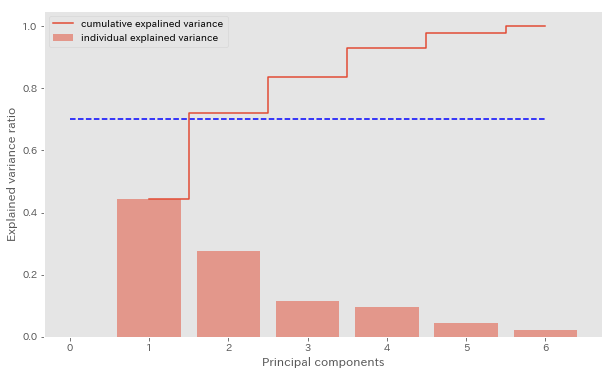

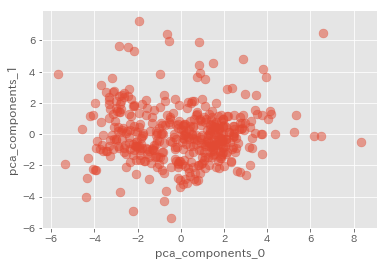

In [27]:
data_log = np.log(data.copy())

# PCAの分散説明率を表示
pca = PCA(n_components = None)
pca = pca.fit(data_log.iloc[:, 3:])
exp_var = pca.explained_variance_ratio_
print("Explained variance: ", exp_var)
cum_exp_var = np.cumsum(exp_var)
print("Cumulative explained variance: ", cum_exp_var)
plt.figure(figsize=(10,6))
plt.bar(range(1,7), exp_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_exp_var, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# PCAによる次元削減
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data_log.iloc[:, 3:])
plt.scatter(data_pca[:, 0], data_pca[:, 1], s=80, alpha=0.5, marker='o')
plt.xlabel("pca_components_0")
plt.ylabel("pca_components_1")
plt.show()

In [32]:
data.drop('Customer ID', axis=1).describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.00,440.00,440.00,440.00,440.00,440.00,440.00,440.00
mean,1.32,2.54,12000.30,5796.27,7951.28,3071.93,2881.49,1524.87
std,0.47,0.77,12647.33,7380.38,9503.16,4854.67,4767.85,2820.11
min,1.00,1.00,3.00,55.00,3.00,25.00,3.00,3.00
25%,1.00,2.00,3127.75,1533.00,2153.00,742.25,256.75,408.25
50%,1.00,3.00,8504.00,3627.00,4755.50,1526.00,816.50,965.50
75%,2.00,3.00,16933.75,7190.25,10655.75,3554.25,3922.00,1820.25
max,2.00,3.00,112151.00,73498.00,92780.00,60869.00,40827.00,47943.00


欠損値はない
卸売額は、Fresh, Grocery, Milk, Frozen, Detergents_Paper, Delicassenの順で大きい
小口から大口まで、多様な顧客を持っている  
ここでは分散を見ている  

In [35]:
data.drop('Customer ID', axis=1).groupby(['Channel']).count()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,298,298,298,298,298,298,298
2,142,142,142,142,142,142,142


channelが指すものは
1:Hoterica
2:Retail
であることがわかる。

In [36]:
#Channel区分別の平均
data.drop('Customer ID', axis=1).groupby(['Channel']).mean()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,2.51,13475.56,3451.72,3962.14,3748.25,790.56,1415.96
2,2.61,8904.32,10716.50,16322.85,1652.61,7269.51,1753.44


In [38]:
data.drop('Customer ID', axis=1).groupby(['Region']).count()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1,77,77,77,77,77,77,77
2,47,47,47,47,47,47,47
3,316,316,316,316,316,316,316


1:Lisbon
2:Oporto
3:Other Region
であることがわかった。

In [39]:
#Region区分別の平均
data.drop('Customer ID', axis=1).groupby(['Region']).mean()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1,1.23,11101.73,5486.42,7403.08,3000.34,2651.12,1354.9
2,1.40,9887.68,5088.17,9218.60,4045.36,3687.47,1159.7
3,1.33,12533.47,5977.09,7896.36,2944.59,2817.75,1620.6


In [40]:
#平均
data.drop('Customer ID', axis=1).groupby(['Channel', 'Region']).mean()

Fresh      Milk   Grocery   Frozen  Detergents_Paper  \
Channel Region                                                            
1       1       12902.25   3870.20   4026.14  3127.32            950.53   
        2       11650.54   2304.25   4395.50  5745.04            482.71   
        3       13878.05   3486.98   3886.73  3656.90            786.68   
2       1        5200.00  10784.00  18471.94  2584.11           8225.28   
        2        7289.79   9190.79  16326.32  1540.58           8410.26   
        3        9831.50  10981.01  15953.81  1513.20           6899.24   

                Delicassen  
Channel Region              
1       1          1197.15  
        2          1105.89  
        3          1518.28  
2       1          1871.94  
        2          1239.00  
        3          1826.21

### 相関関係を確認する

### milkとGroceryの相関関係が高い
### Detergents_PaperとGroceryの相関関係が高い

In [66]:
import seaborn as sns
corr_df = data.drop('Customer ID', axis=1).corr(method="pearson")
corr_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.00,6.20e-02,-0.17,0.46,6.09e-01,-0.20,6.36e-01,0.06
Region,0.06,1.00e+00,0.06,0.03,7.70e-03,-0.02,-1.48e-03,0.05
Fresh,-0.17,5.53e-02,1.00,0.10,-1.19e-02,0.35,-1.02e-01,0.24
Milk,0.46,3.23e-02,0.10,1.00,7.28e-01,0.12,6.62e-01,0.41
Grocery,0.61,7.70e-03,-0.01,0.73,1.00e+00,-0.04,9.25e-01,0.21
Frozen,-0.20,-2.10e-02,0.35,0.12,-4.02e-02,1.00,-1.32e-01,0.39
Detergents_Paper,0.64,-1.48e-03,-0.10,0.66,9.25e-01,-0.13,1.00e+00,0.07
Delicassen,0.06,4.52e-02,0.24,0.41,2.05e-01,0.39,6.93e-02,1.00


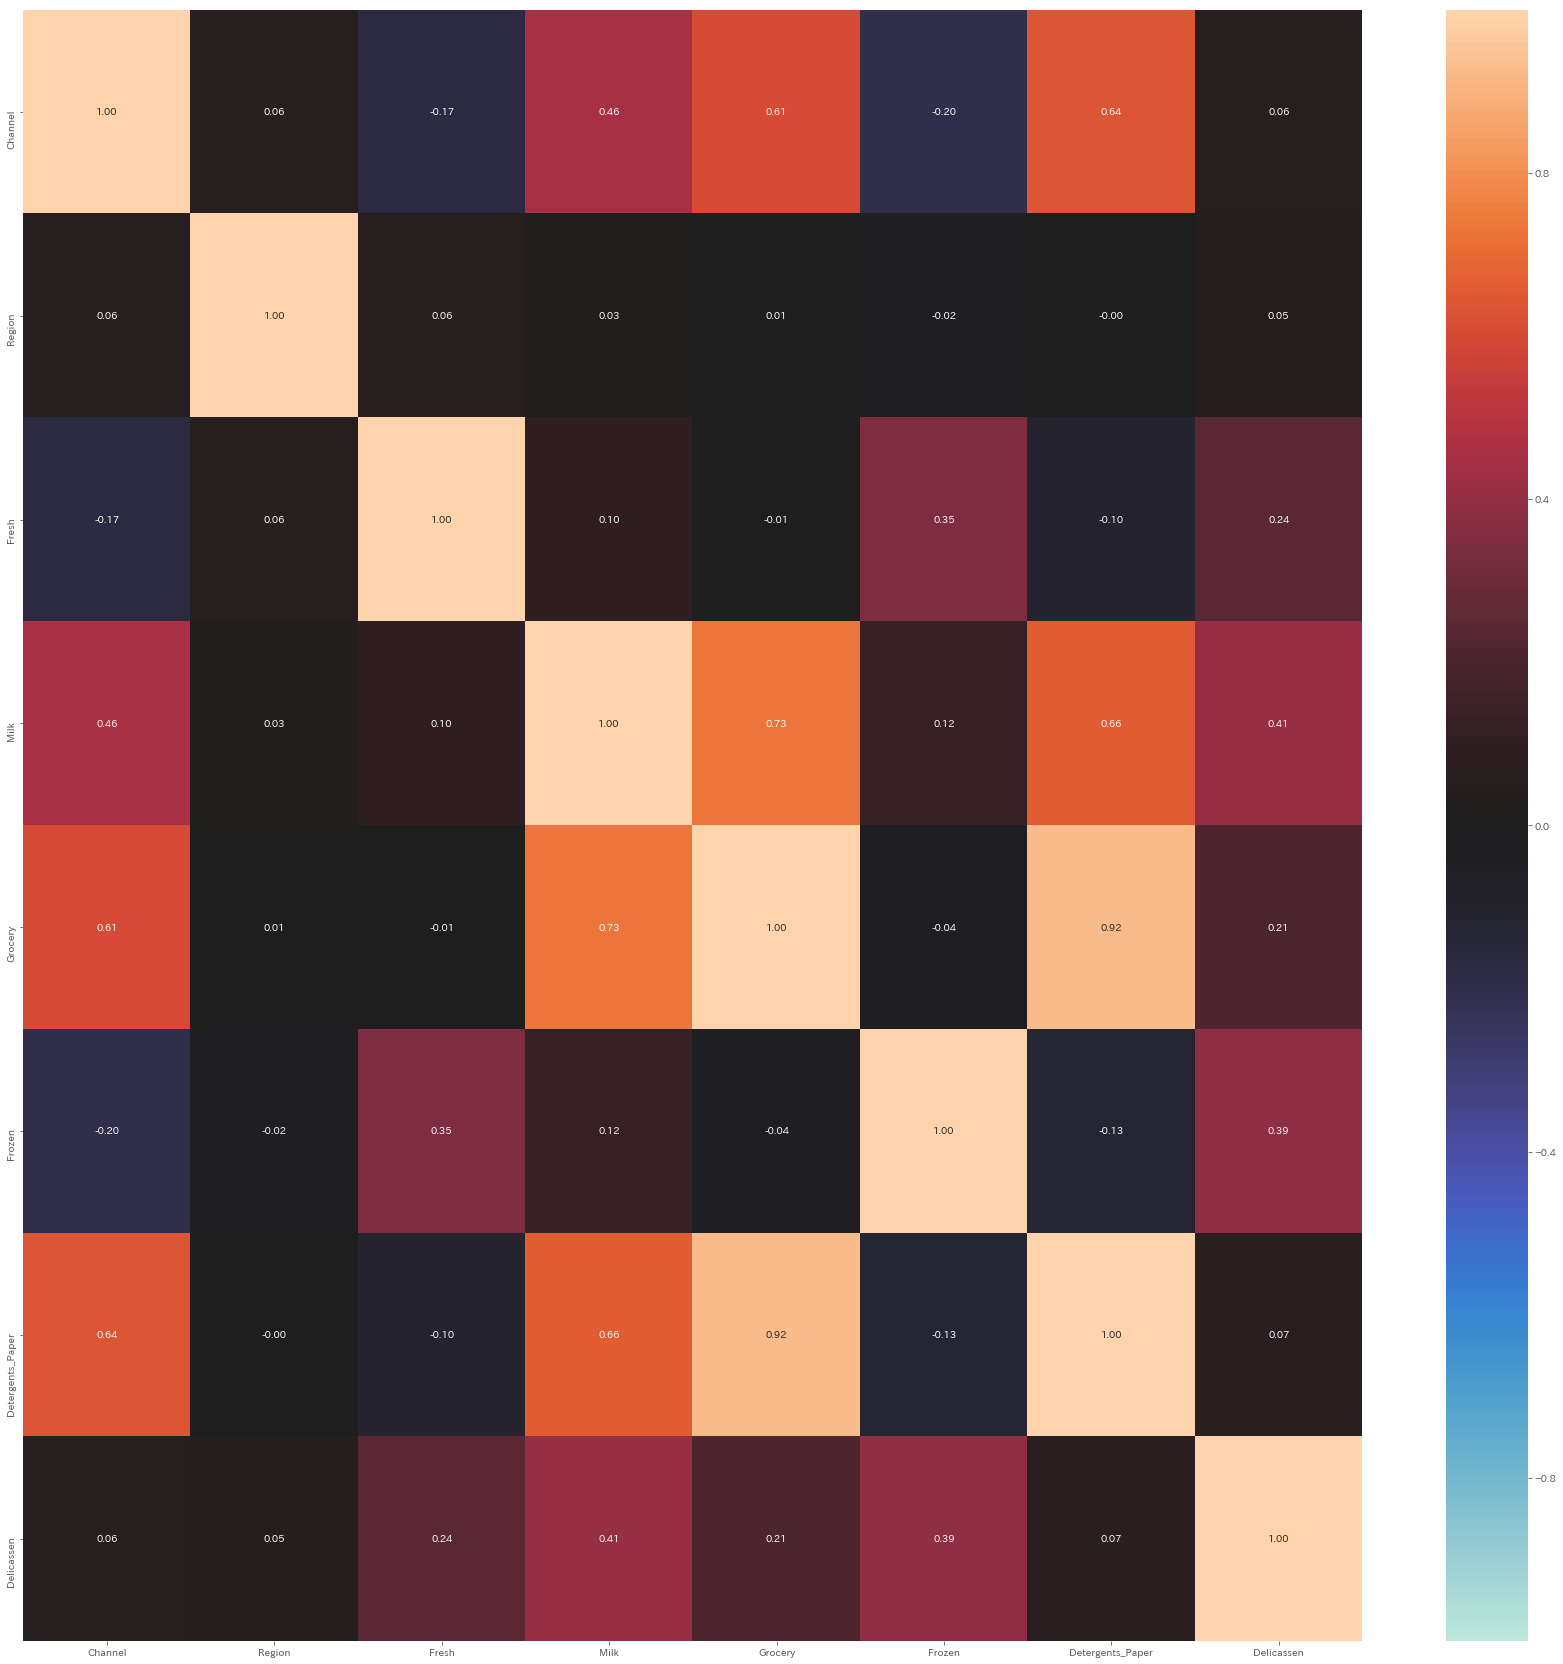

In [67]:
plt.figure(figsize=(30,30))

#ヒートマップを作成
sns.heatmap(corr_df,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            fmt='.2f',
            annot=True, # True:格子の中に値を表示
            xticklabels=corr_df.columns.values,
            yticklabels=corr_df.columns.values, 
           )

#出力
plt.show()

### Channel別、Region別の相関係数を確認する

In [68]:
#Channel別のデータを作成
df_channel1 = data.drop('Customer ID', axis=1)[data['Channel']==1].drop('Channel', axis=1)
df_channel2 = data.drop('Customer ID', axis=1)[data['Channel']==2].drop('Channel', axis=1)

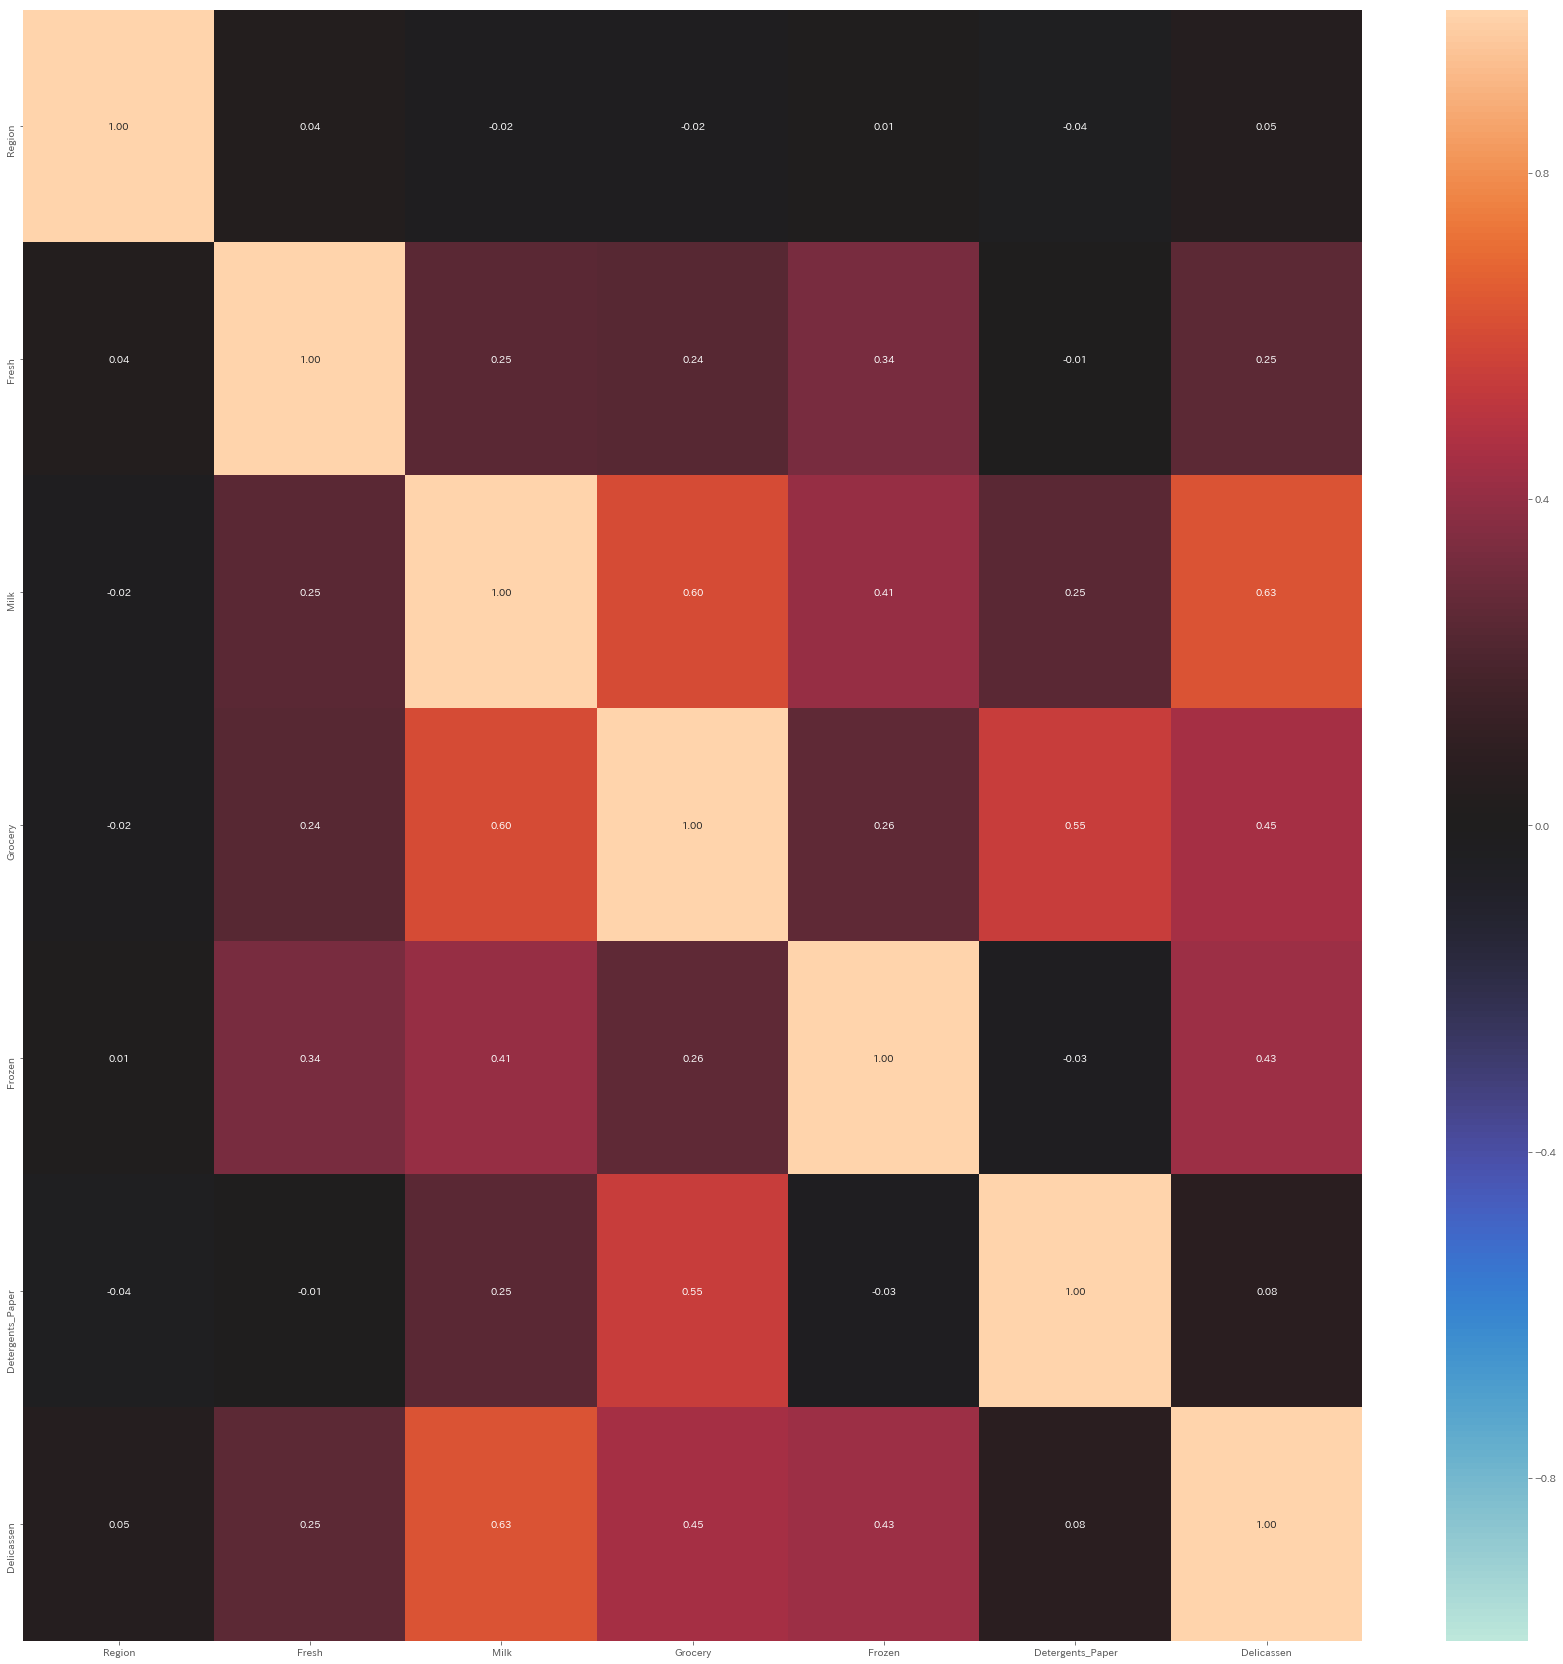

In [69]:
#相関係数行列を作成
corr_df_channel1 = df_channel1.corr(method="pearson")

#図を拡大する
plt.figure(figsize=(30,30))

#ヒートマップを作成
sns.heatmap(corr_df_channel1,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            fmt='.2f',
            annot=True, # True:格子の中に値を表示
            xticklabels=corr_df_channel1.columns.values,
            yticklabels=corr_df_channel1.columns.values, 
           )

#出力
plt.show()

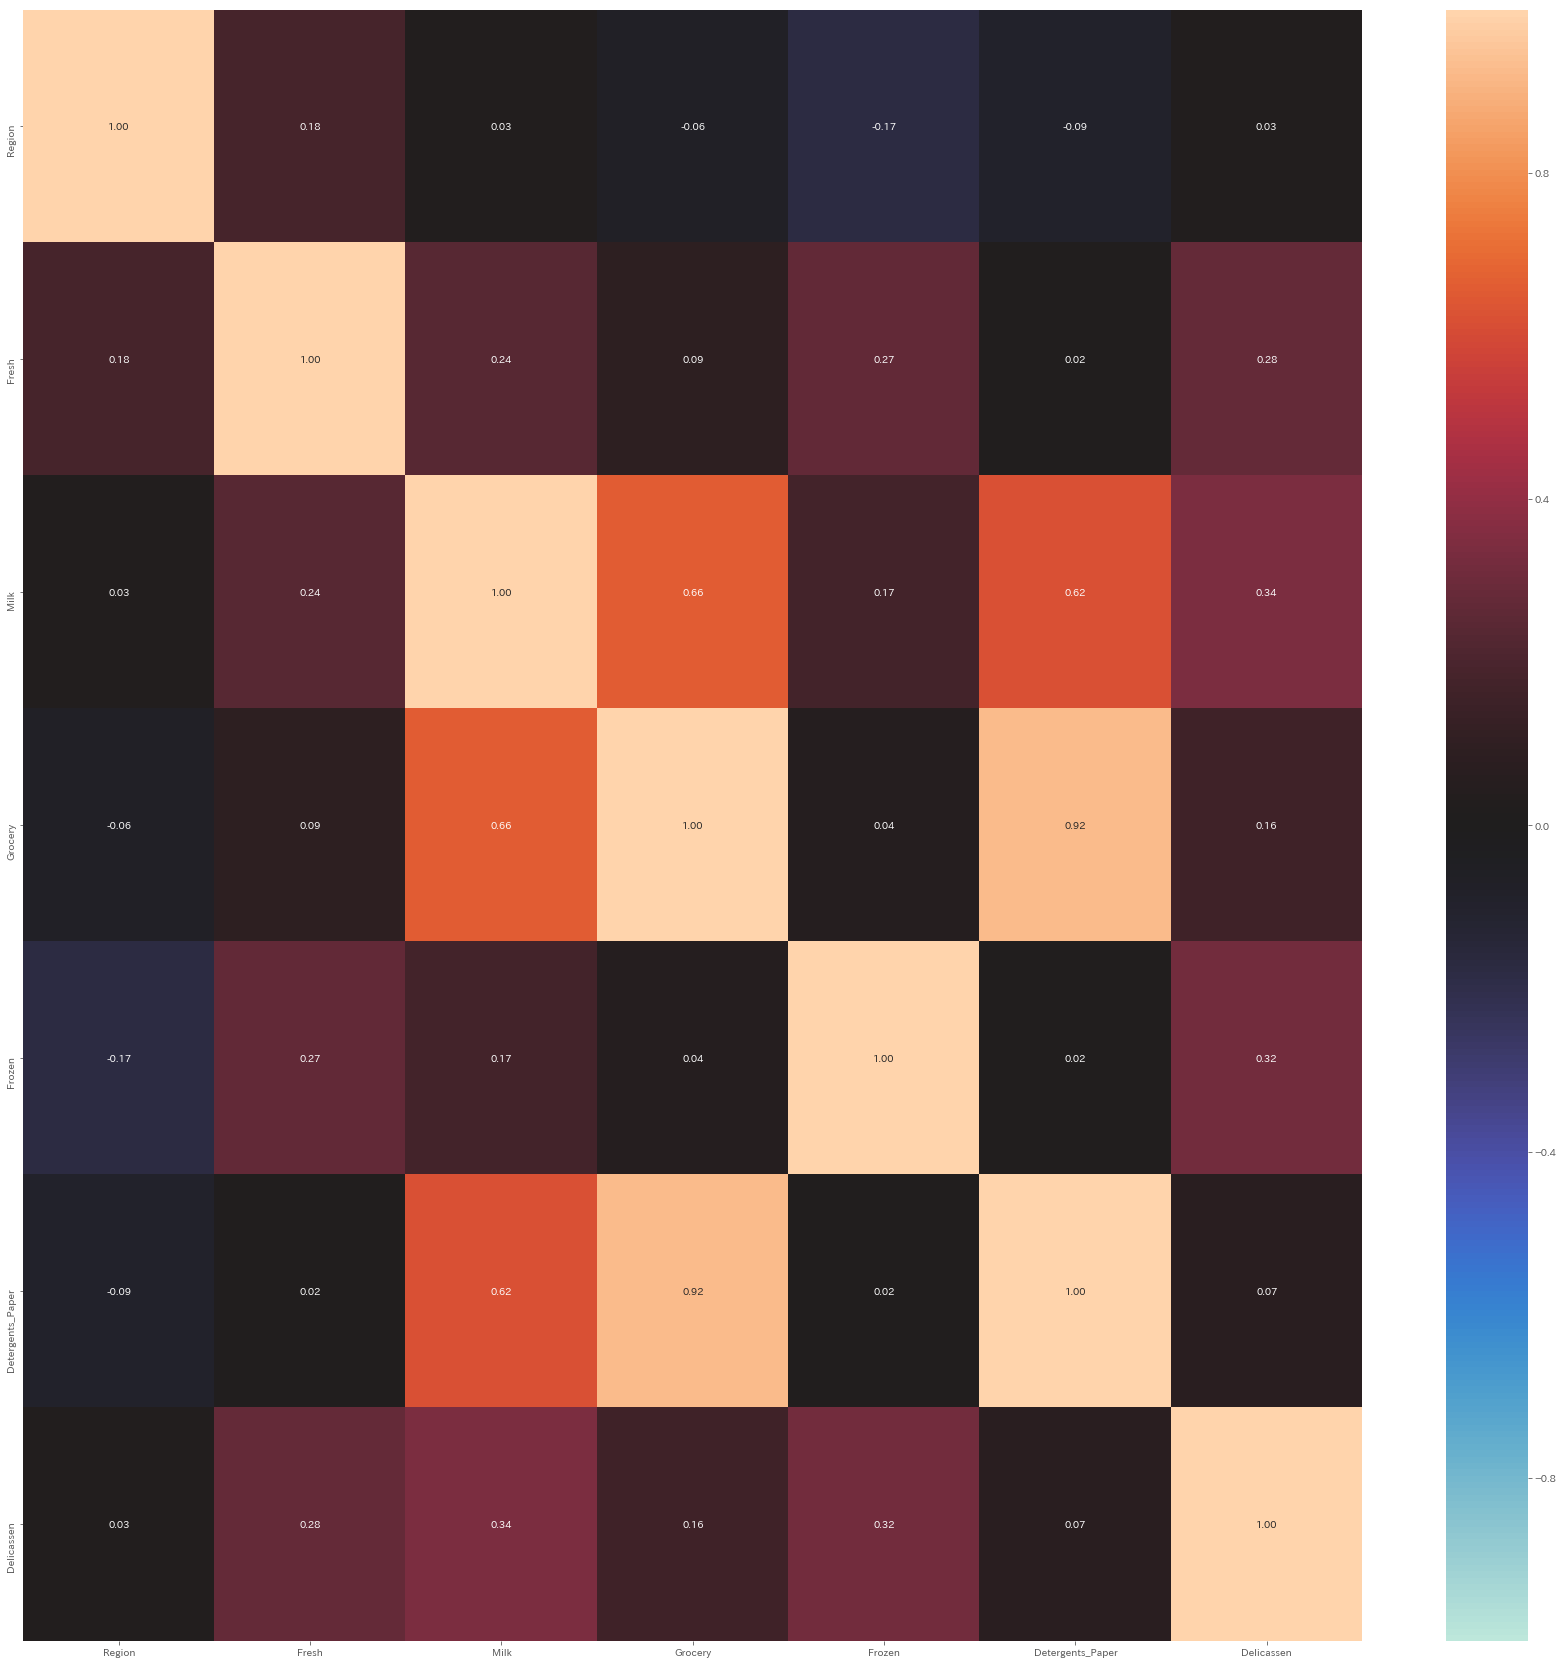

In [70]:
#相関係数行列を作成
corr_df_channel2 = df_channel2.corr(method="pearson")

#図を拡大する
plt.figure(figsize=(30,30))

#ヒートマップを作成
sns.heatmap(corr_df_channel2,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            fmt='.2f',
            annot=True, # True:格子の中に値を表示
            xticklabels=corr_df_channel2.columns.values,
            yticklabels=corr_df_channel2.columns.values, 
           )

#出力
plt.show()

In [41]:
#Region別のデータを作成
#1:Lisbon 2:Oporto 3:Other Region
df_region1 = data.drop('Customer ID', axis=1)[data['Region']==1].drop('Region', axis=1)
df_region2 = data.drop('Customer ID', axis=1)[data['Region']==2].drop('Region', axis=1)
df_region3 = data.drop('Customer ID', axis=1)[data['Region']==3].drop('Region', axis=1)

#相関係数行列を作成
corr_df_region1 = df_region1.corr(method="pearson")

#相関係数行列を作成
corr_df_region2 = df_region2.corr(method="pearson")

#相関係数行列を作成
corr_df_region3 = df_region3.corr(method="pearson")

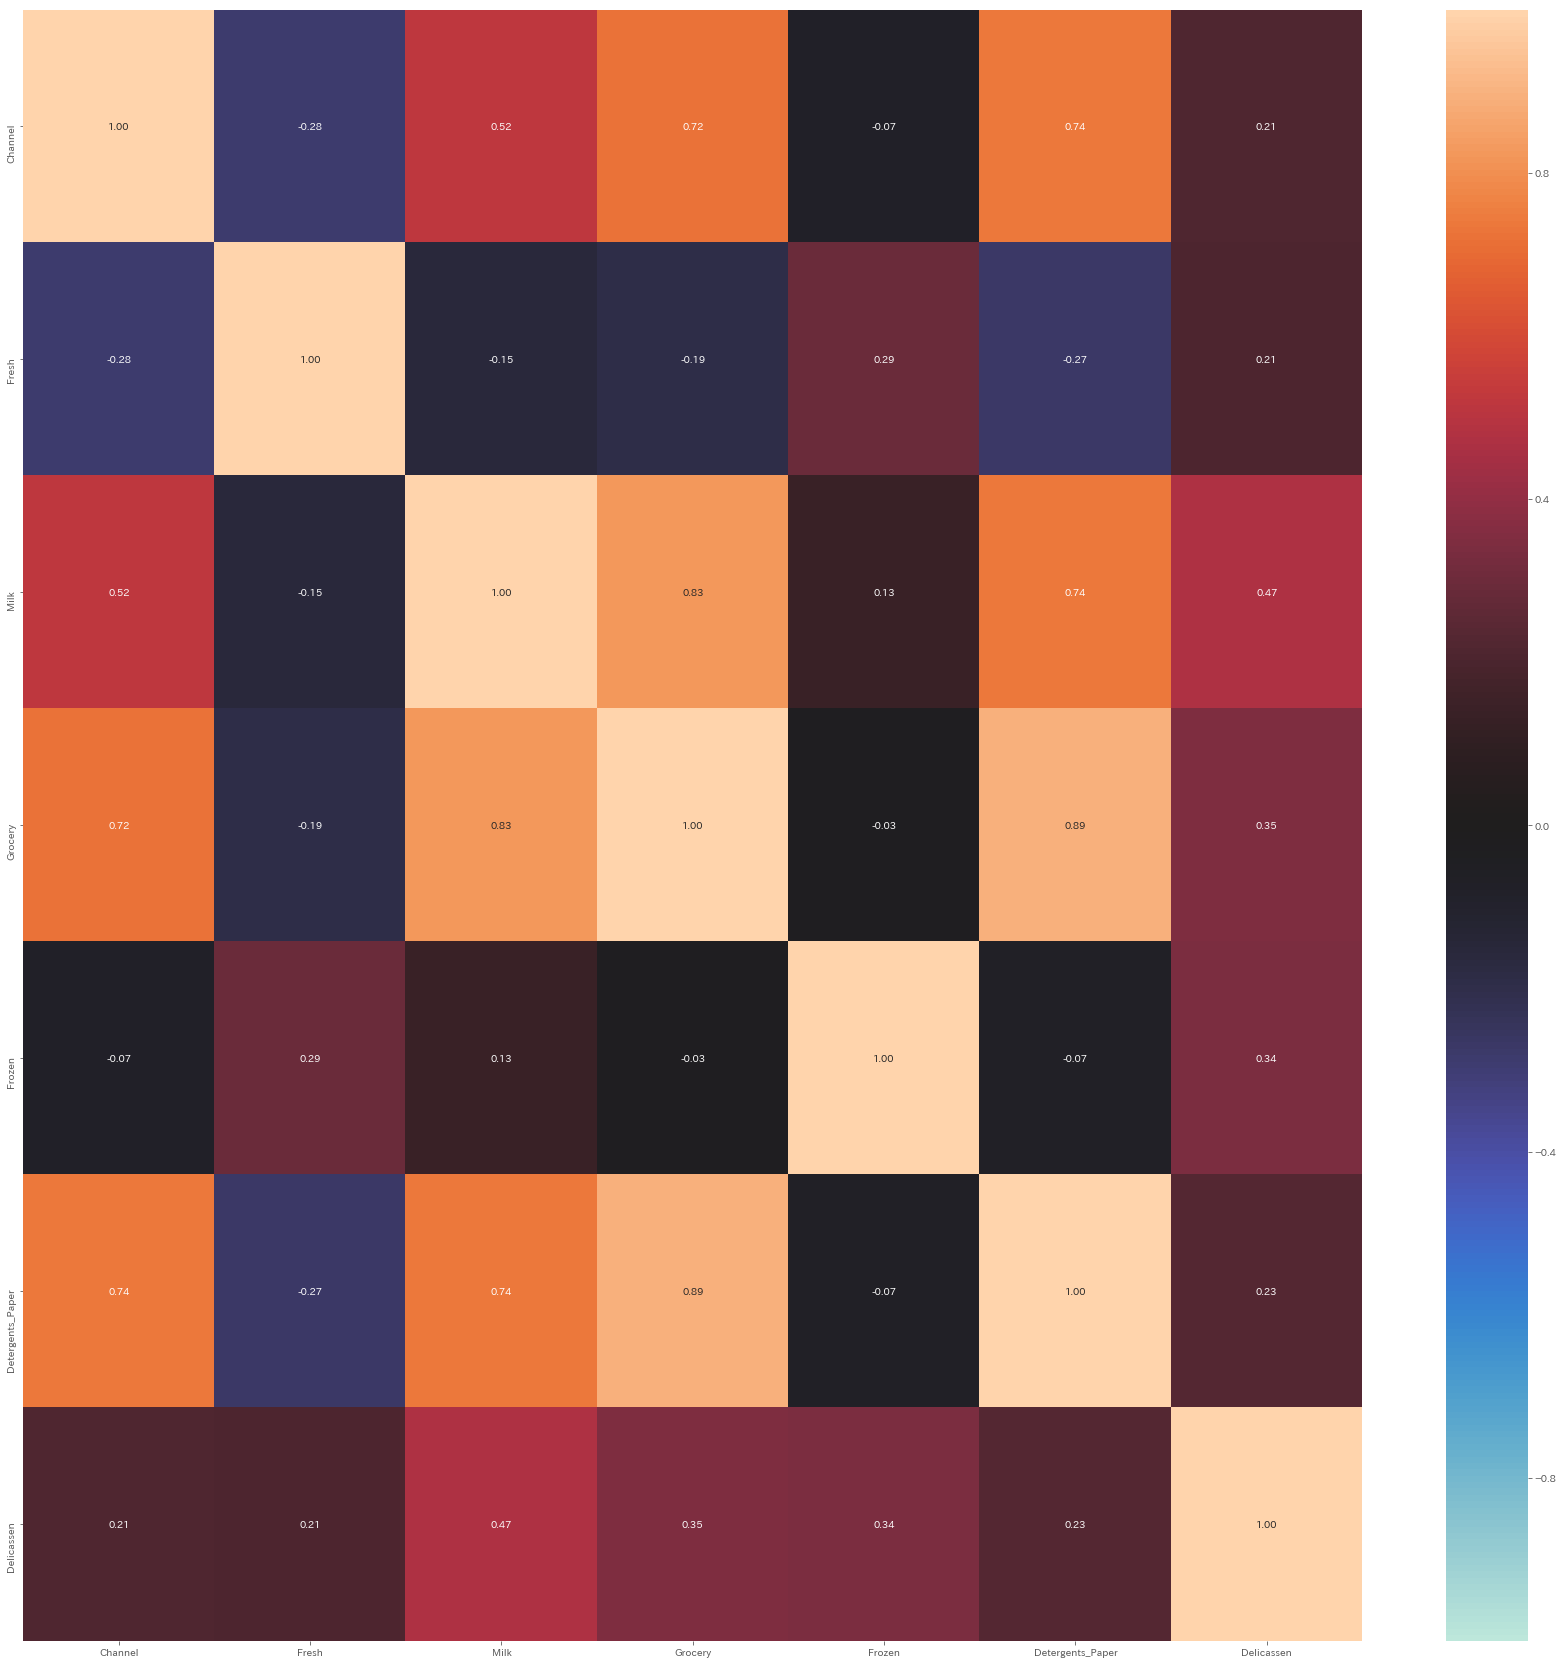

In [52]:
#図を拡大する
plt.figure(figsize=(30,30))

#ヒートマップを作成
sns.heatmap(corr_df_region1,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            fmt='.2f',
            annot=True, # True:格子の中に値を表示
            xticklabels=corr_df_region1.columns.values,
            yticklabels=corr_df_region1.columns.values, 
           )

#出力
plt.show()

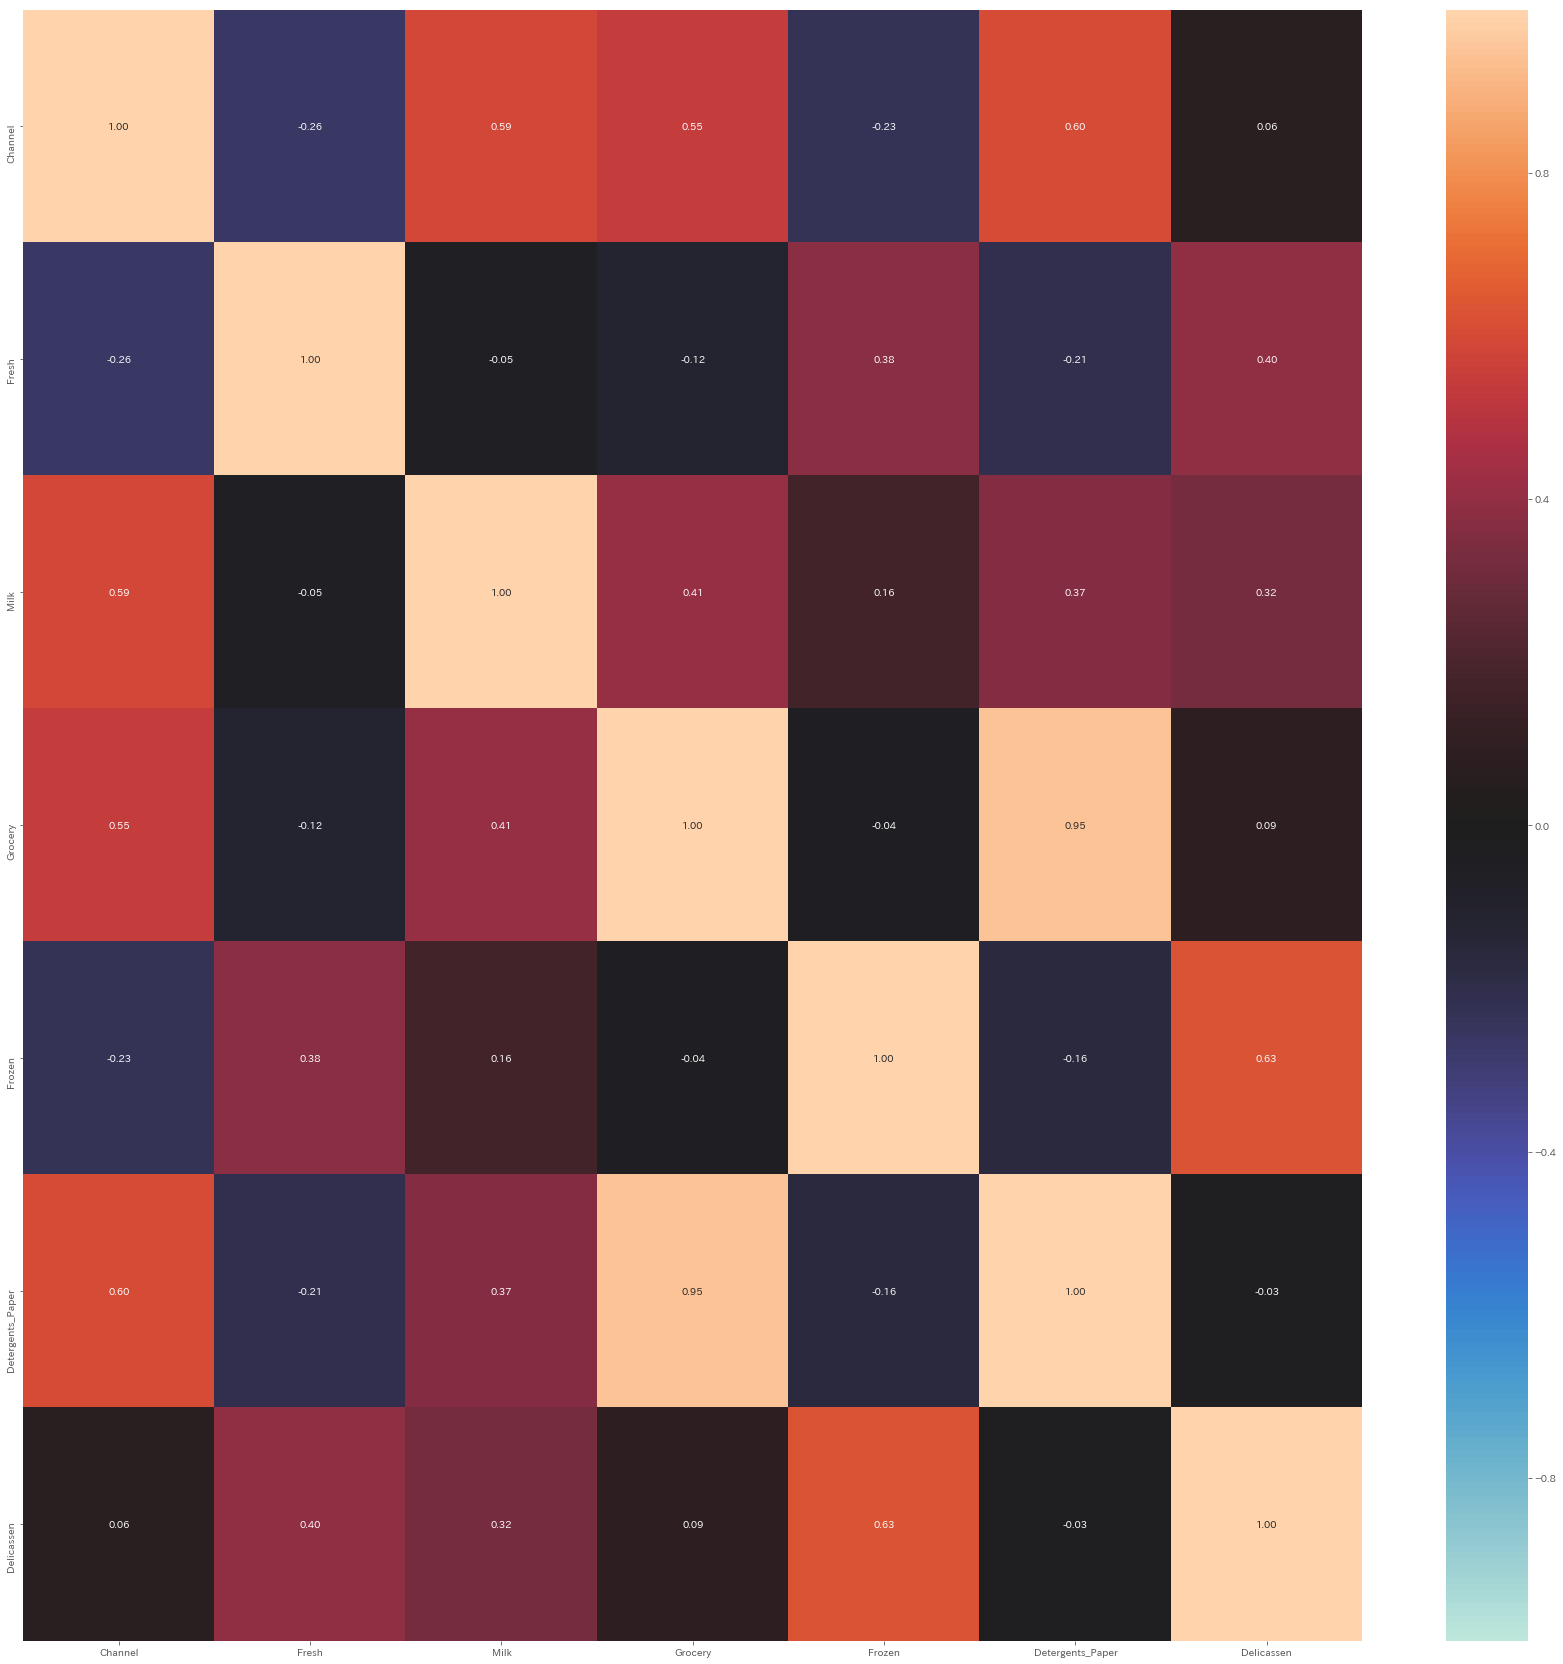

In [73]:
#図を拡大する
plt.figure(figsize=(30,30))

#ヒートマップを作成
sns.heatmap(corr_df_region2,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            fmt='.2f',
            annot=True, # True:格子の中に値を表示
            xticklabels=corr_df_region2.columns.values,
            yticklabels=corr_df_region2.columns.values, 
           )

#出力
plt.show()

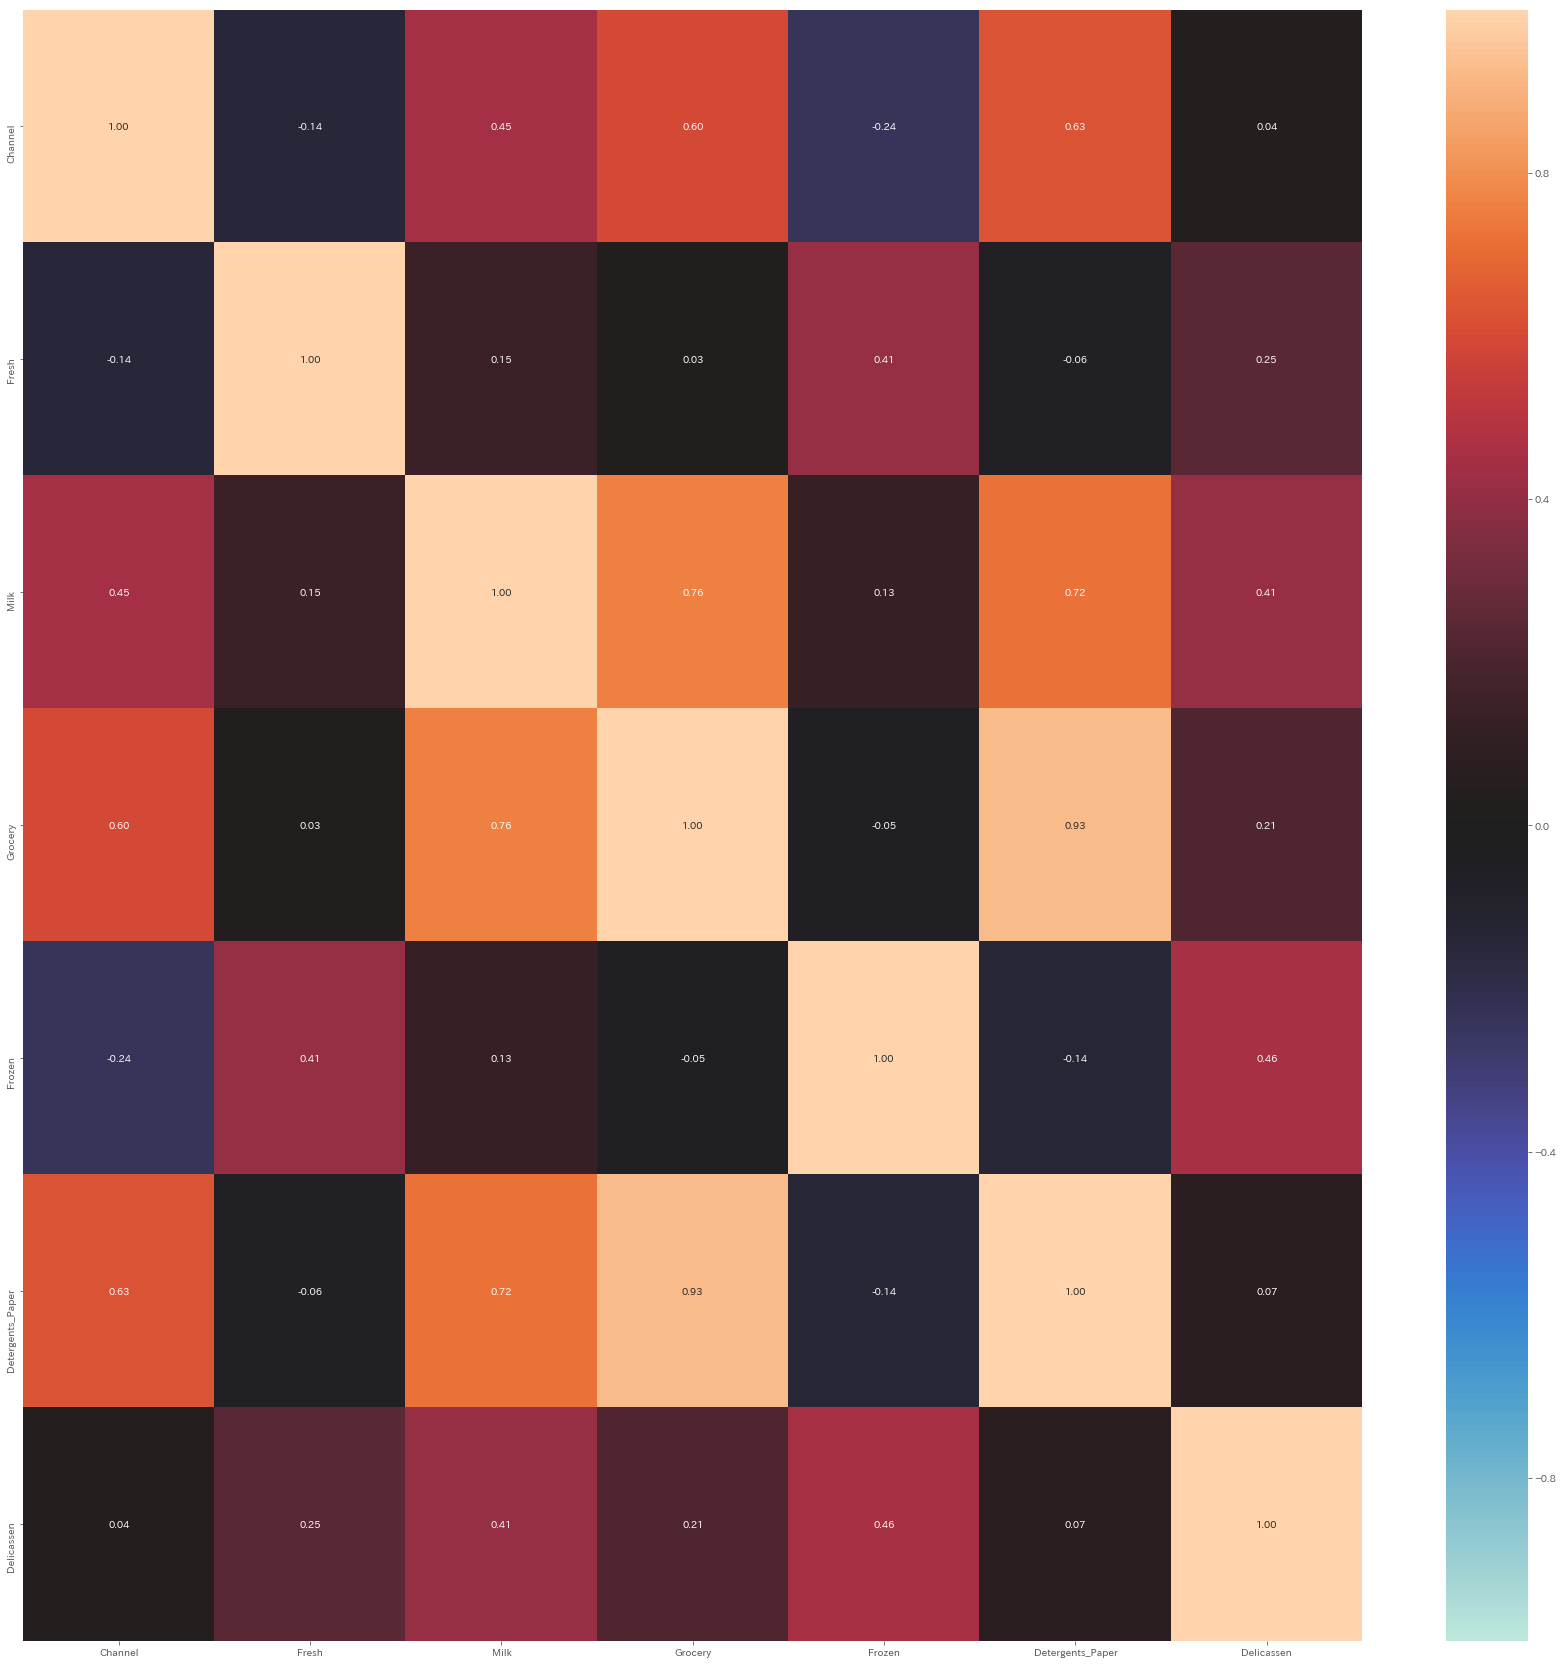

In [74]:
#図を拡大する
plt.figure(figsize=(30,30))

#ヒートマップを作成
sns.heatmap(corr_df_region3,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            fmt='.2f',
            annot=True, # True:格子の中に値を表示
            xticklabels=corr_df_region3.columns.values,
            yticklabels=corr_df_region3.columns.values, 
           )

#出力
plt.show()

【問題3】（アドバンス課題）シルエット図
コーディング

${k}$
 を決める助けになるものとしてシルエット図もあります。

Matplotlibを使い可視化するコードは用意しました。以下を与えてくあさい。

silhouette_vals : shape(n_samples,)のndarray、各データ点のシルエット係数

silhouette_avg : float、シルエット係数の平均値

y_km : shape(n_samples,)のndarray、各データ点のクラスタラベル名

cluster_labels : list、クラスタのラベル名のリスト

n_clusters : int、クラスタ数

${n}$
 番目のデータ点に対するシルエット係数 
${s_n}$
 は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。
$${s_n = \frac{b_n-a_n}{max(b_n,a_n)}}$$
 ${a_n}$
: 凝集度。同じクラスタ内の他のデータ点との距離の平均値。

${b_n}$
 : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。

乖離度 
${b}$
 が大きく、凝集度 
${a}$
 が小さい時が理想的であり、シルエット係数 
${s}$
 は1に近くなります。

In [ ]:
def plot_silhouette(self, X):
            """
            シルエット図を出力する

            Parameters
            ----------
            X : 次の形のndarray, shape (n_samples, n_features)
                サンプル

            Returns
            -------
            plot
                シルエット図

            """

            #凝集度を計算する
            an = self.degree_of_aggregation(X)

            #乖離度を計算する
            bn = self.degree_of_divergence(X)

            #凝集度と乖離度を列で結合
            an_bn = np.concatenate([an.reshape(an.shape[0],1), bn.reshape(bn.shape[0],1)], axis=1)

            #各データのシルエット係数
            silhouette_vals = (bn - an) / np.max(an_bn, axis=1)

            #シルエット係数の平均値
            silhouette_avg = np.mean(silhouette_vals)

            #各データ点のクラスララベル名
            y_km = self.classifications_label

            #クラスタのラベル名のリスト
            cluster_labels = np.arange(0, self.k, 1)

            #クラスタ数
            n_clusters = self.k


            #シルエット図を出力する
            y_ax_lower, y_ax_upper = 0, 0
            yticks = []
            for i, c in enumerate(cluster_labels):
                c_silhouette_vals = silhouette_vals[y_km == c]
                c_silhouette_vals.sort()
                y_ax_upper += len(c_silhouette_vals)
                color = cm.jet(i / n_clusters)
                plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
                yticks.append((y_ax_lower + y_ax_upper) / 2)
                y_ax_lower += len(c_silhouette_vals)

            plt.axvline(silhouette_avg, color="red", linestyle="--")
            plt.yticks(yticks, cluster_labels + 1)
            plt.ylabel('Cluster')
            plt.xlabel('Silhouette coefficient')
            plt.show()


/anaconda3/envs/DIC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/DIC/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/DIC/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


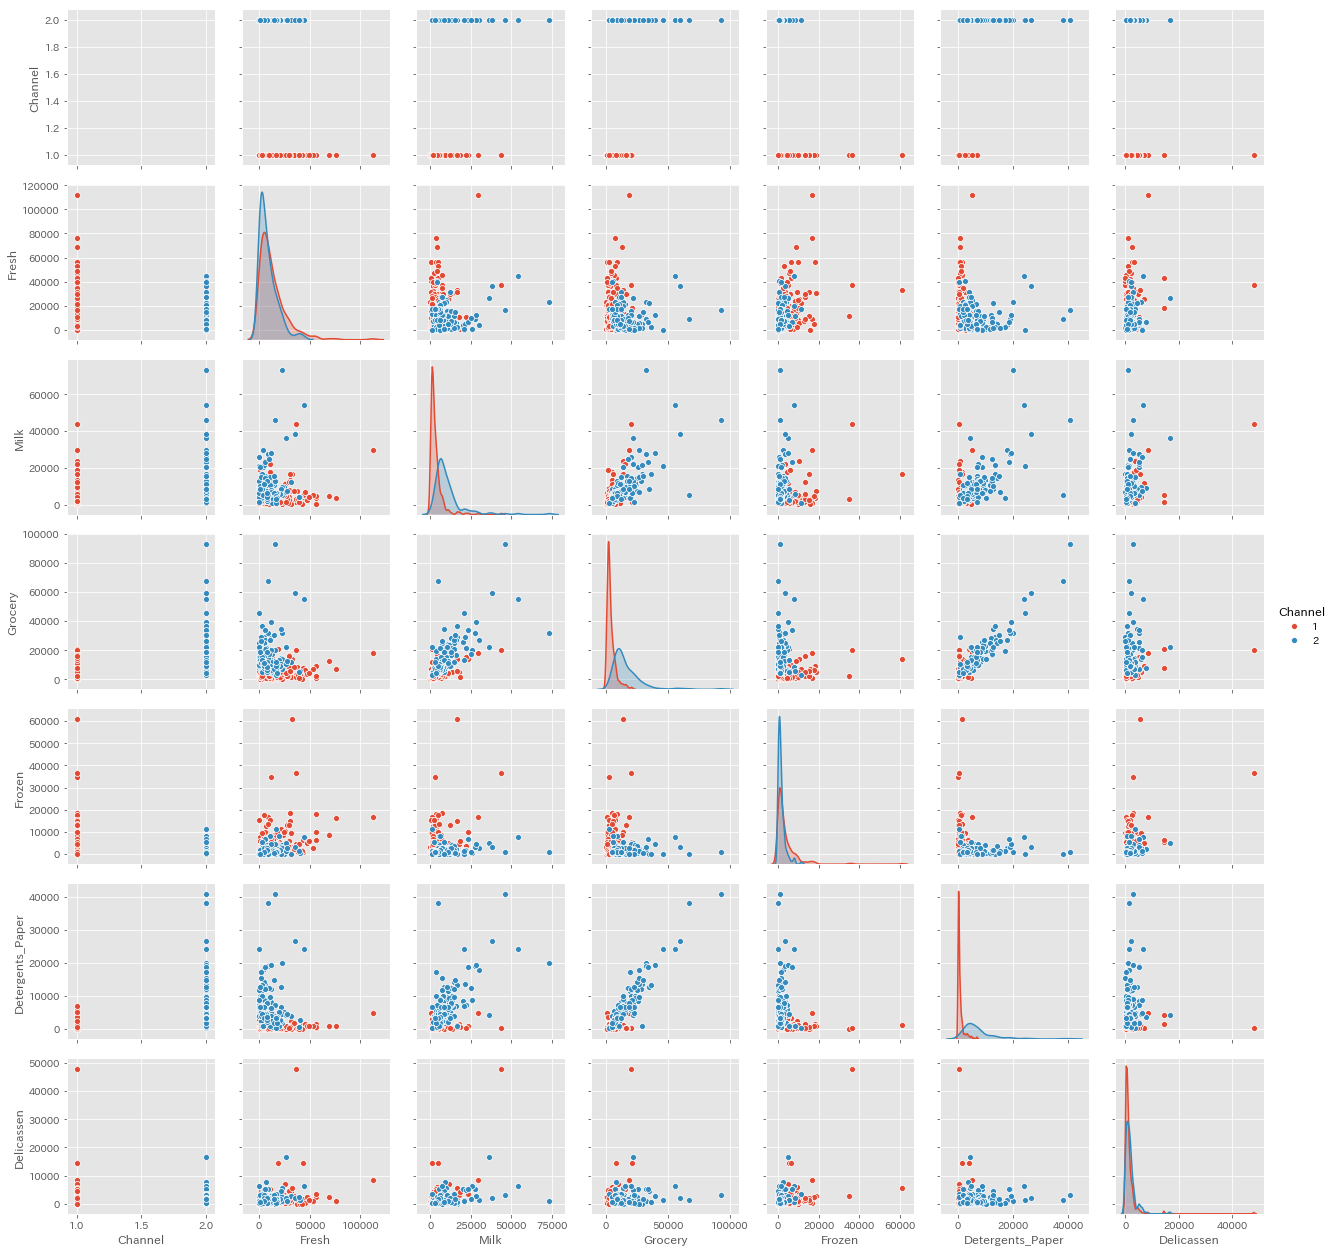

In [61]:
data1 = data.drop(["Customer ID","Region"],axis=1)
sns.pairplot(data1, hue='Channel')

/anaconda3/envs/DIC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/DIC/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/DIC/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


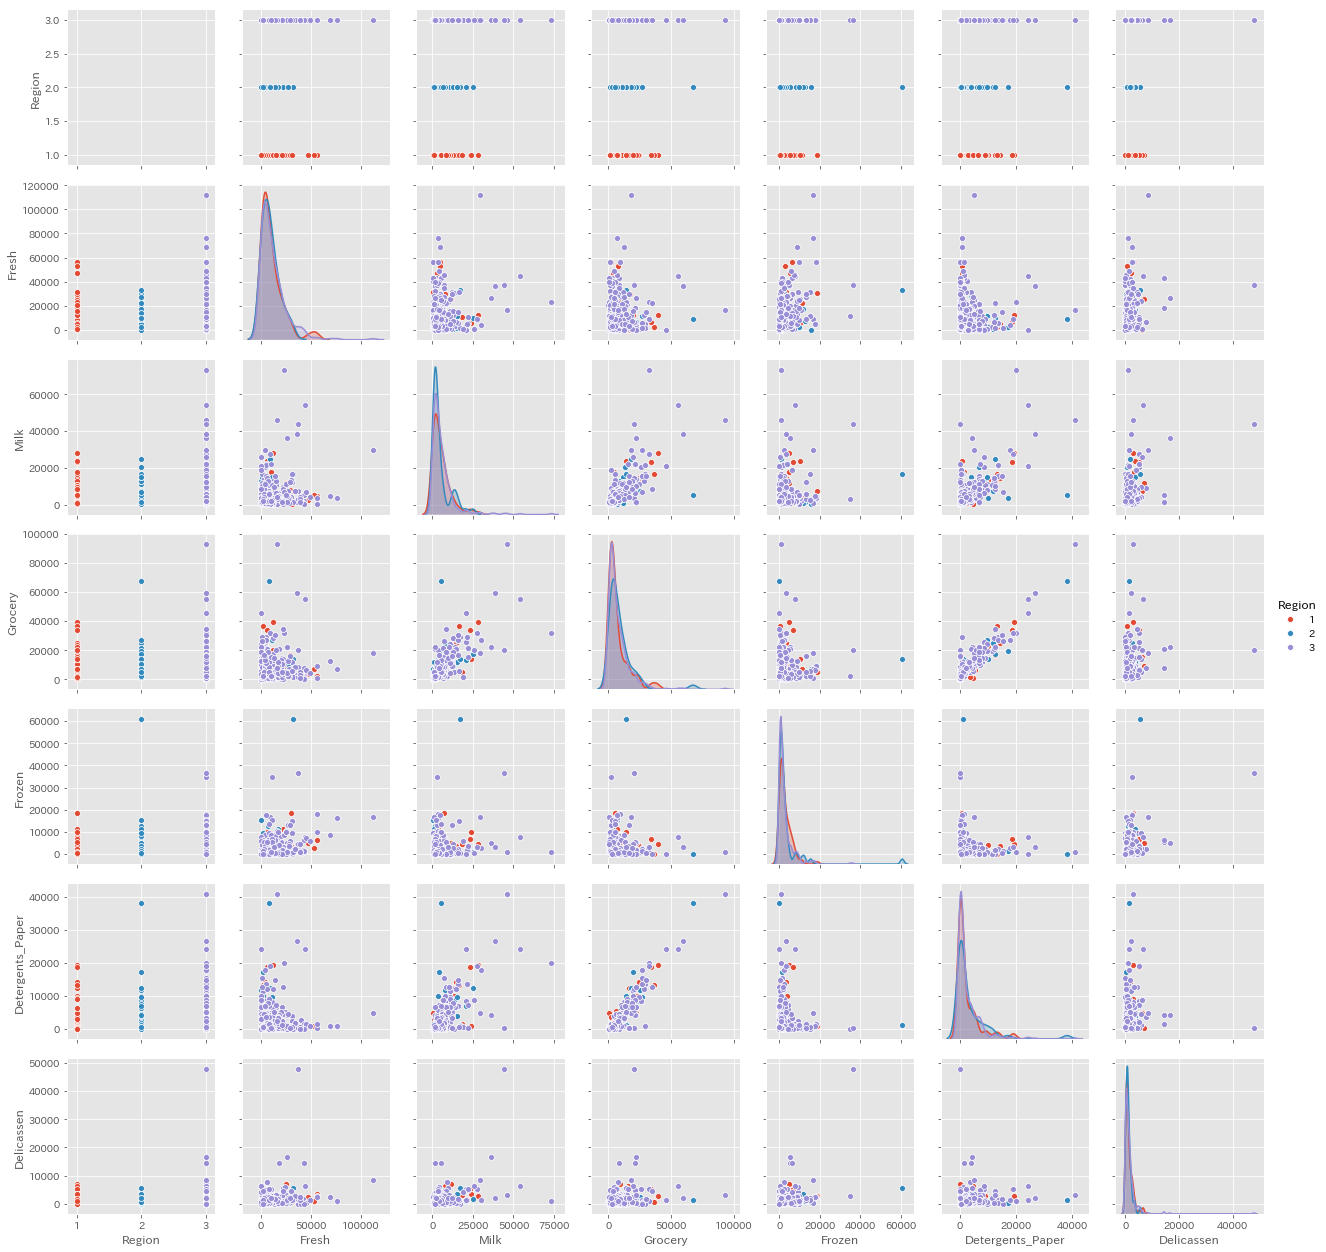

In [4]:
data2 = data.drop(["Customer ID","Channel"],axis=1)
sns.pairplot(data2, hue='Region')
#Region関連で見ると３地域とも偏りはない。

/anaconda3/envs/DIC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/DIC/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/DIC/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


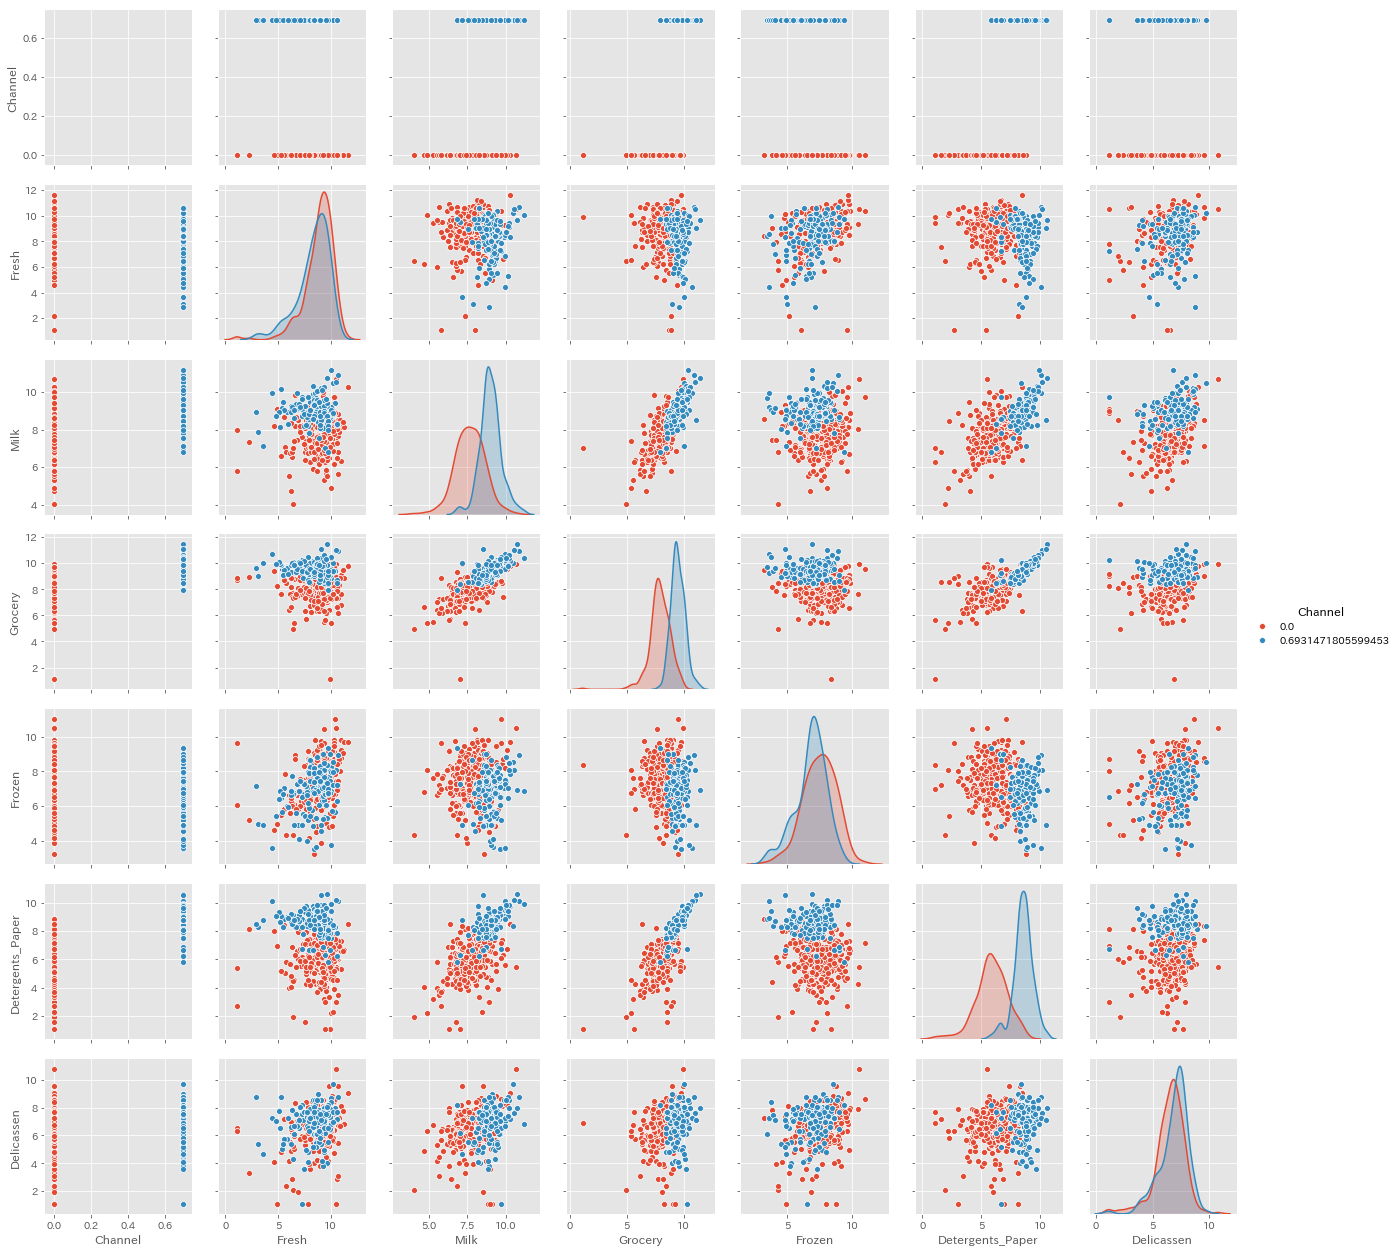

In [5]:
data1 = data.drop(["Customer ID","Region"],axis=1)
data_log1 = np.log(data1)
sns.pairplot(data_log1, hue='Channel')

以前MILKとGroceryは相関関係が高いと分析したがChannelの、このプロットから似たような分布の偏りがある。Logで見ると偏りは顕著

/anaconda3/envs/DIC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/DIC/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/envs/DIC/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


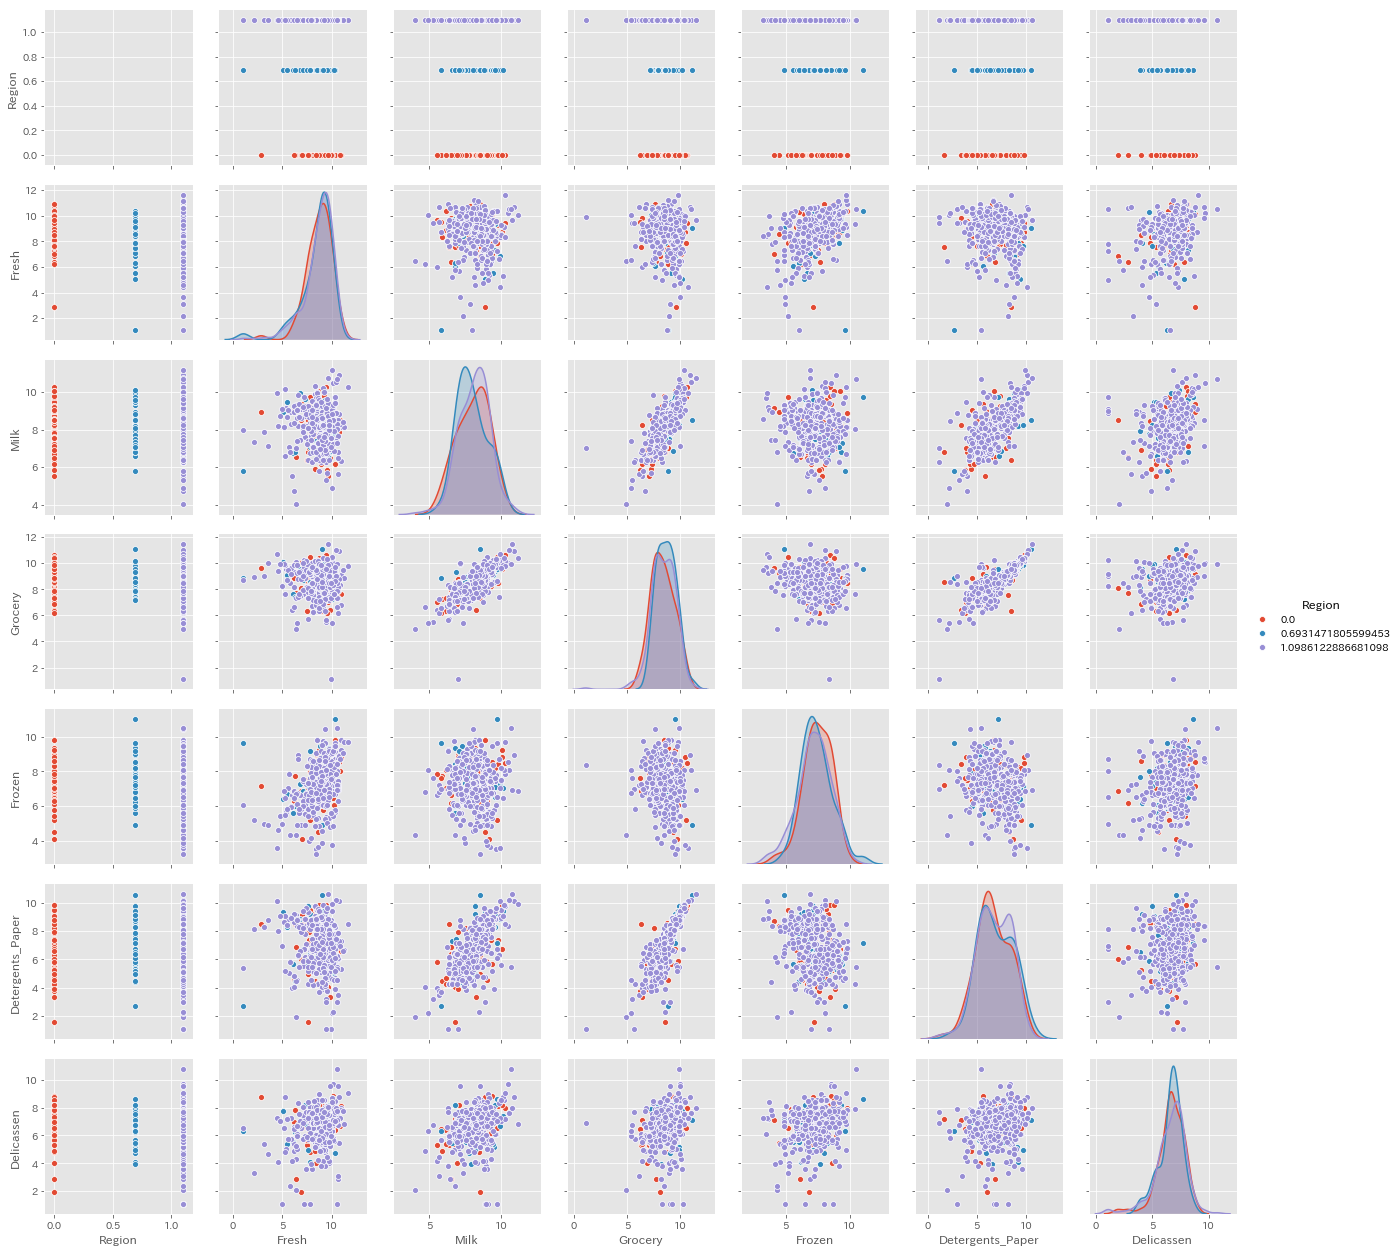

In [7]:
data2 = data.drop(["Customer ID","Channel"],axis=1)
data2_log = np.log(data2)
sns.pairplot(data2_log, hue='Region')

Regionは特に分かる事は無い